This notebook is just meant to test the codes before I compile them as .py files.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, ticker
from astropy.io import fits
import astropy.io.ascii as astropy_ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from src.utils.constants import *

from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# Plot configurations
GOLDEN_RATIO = 0.5*(1+np.sqrt(5))
FIGURE_HEIGHT = 5
FIGURE_WIDTH = FIGURE_HEIGHT*GOLDEN_RATIO
DEFAULT_FIGSIZE = (FIGURE_WIDTH, FIGURE_HEIGHT)

# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = 'cm'

ROOT_PATH = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0'

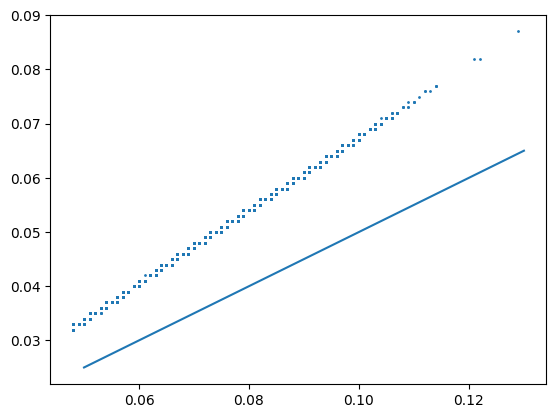

In [8]:
df = pd.read_csv('data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)

plt.scatter(df['elogIe_J'], df['elogRe_J'], s=1)
plt.plot([0.05, 0.13], [0.025, 0.065])
# df.columns

In [3]:
df_sdss = pd.read_csv('data/preprocessed/no_jrl/sdss.csv')

df_lamost = pd.read_csv('data/preprocessed/no_jrl/lamost.csv')

df_lamost

,tmass
0,2MASXJ07315268+2804333
1,2MASXJ16431597+2636339
2,2MASXJ13314582+2515015
3,2MASXJ14120785+3643427
4,2MASXJ13365345+2607052
...,...
962,2MASXJ01562225+2645347
963,2MASXJ09110010+3952434
964,2MASXJ08505330+4753496
965,2MASXJ23234234+1725013


# 1. Fetch coordinates (ra, dec) from raw data

In [ ]:
# 6dFGS
df = pd.read_csv('data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)

# ra is still in hour -> need to convert to degrees
df_test = df[['ra', 'dec']]

In [ ]:
Table.from_pandas(df_test).write('6dfgs_coord.ascii', format='ipac', overwrite=True)

In [ ]:
# LAMOST
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df = pd.DataFrame(hdul[1].data)

df[['ra', 'dec']].describe()

In [ ]:
# # sdss
# df = pd.read_csv('data/raw/sdss/SDSS_spectro_mrafifrbbn.csv')

# df[['ra', 'dec']].describe()

# 2. Merge the spectroscopy and photometry

In [ ]:
# Compare the original raw data to 2MASS (check if the order is the same)
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_lamost_spectro = pd.DataFrame(hdul[1].data)
    
df_lamost_tmass = pd.read_csv('data/raw/2mass/lamost_tmass.csv', low_memory=False)

df = pd.merge(df_lamost_spectro[['ra', 'dec']], df_lamost_tmass[['ra_01', 'dec_01']], left_index=True, right_index=True)

df['delta_ra'] = df['ra_01']-df['ra']
df['delta_dec'] = df['dec_01']-df['dec']


df[['delta_ra', 'delta_dec']].describe()

In [ ]:
# Compare the original raw data to 2MASS
df_6df_spectro = pd.read_csv('data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)
df_6df_spectro['ra'] = df_6df_spectro['ra']*15

df_6df_tmass = pd.read_csv('data/raw/2mass/6dfgs_tmass.csv', low_memory=False)

df = pd.merge(df_6df_spectro[['ra', 'dec']], df_6df_tmass[['ra_01', 'dec_01']], left_index=True, right_index=True)

df['delta_ra'] = df['ra_01']-df['ra']
df['delta_dec'] = df['dec_01']-df['dec']

df[['delta_ra', 'delta_dec']].describe()

# Coba2 cross-matching

In [ ]:
# LAMOST
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_lamost = Table(hdul[1].data).to_pandas()

df_sdss = pd.read_csv('data/raw/sdss/SDSS_spectro_mrafifrbbn.csv')

In [ ]:
sdss_coords = SkyCoord(ra=df_sdss['ra'].to_numpy()*u.deg, dec=df_sdss['dec'].to_numpy()*u.deg)
lamost_coords = SkyCoord(ra=df_lamost['ra'].to_numpy()*u.deg, dec=df_lamost['dec'].to_numpy()*u.deg)

In [ ]:
idx, sep2d, _ = lamost_coords.match_to_catalog_sky(sdss_coords)
is_counterpart = sep2d < 1.*u.arcsec

df_lamost['sdss_idx'] = idx
df_lamost['sdss_counterpart'] = is_counterpart

df_lamost = df_lamost[df_lamost['sdss_counterpart']==True]

In [ ]:
df_lamost_sdss = df_lamost.merge(df_sdss, left_on='sdss_idx', right_index=True)

In [ ]:
df_lamost_sdss[['ra_x', 'dec_x', 'ra_y', 'dec_y', 'veldisp_x', 'sigmaStars']]

## Main code for merging

### 6dFGS: Combine Vizier data (what I used throughout my thesis)

In [ ]:
# FP data
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_fp = Table(hdul[1].data).to_pandas()
    
df_fp.head()

In [ ]:
# veldisp data
with fits.open('data/raw/6dfgs/sdfgs_veldisp_vizier.fits') as hdul:
    df_veldisp = Table(hdul[1].data).to_pandas()

veldisp_columns = ['_6dFGS', 'MJD', 'z', 'S_N', 'R', 'Vd', 'e_Vd', '_RA', '_DE']
df_veldisp = df_veldisp[veldisp_columns]

df_veldisp.head()

In [ ]:
df_6dfgs = df_fp.merge(df_veldisp, on='_6dFGS', how='inner')

df_6dfgs

In [ ]:
df_6df_campbell = pd.read_csv('data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)[['6dFGSid', 'ra', 'dec']]
df_6df_campbell['ra'] = df_6df_campbell['ra']

In [ ]:
df_compare = df_6dfgs.merge(df_6df_campbell, left_on='_6dFGS', right_on='6dFGSid')
df_compare['DELTA_RA'] = (df_compare['RAJ2000']-df_compare['ra'])*15*3600
df_compare['DELTA_DE'] = (df_compare['DEJ2000']-df_compare['dec'])*3600
df_compare[['RAJ2000', 'DEJ2000', 'ra', 'dec', 'DELTA_RA', 'DELTA_DE']]

In [ ]:
# Selidiki perbedaan ra_01 dec_01 (input) dan ra dan dec (dari 2MASS)
df = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')

coords_1 = SkyCoord(ra=df['ra_01'].to_numpy()*u.deg, dec=df['dec_01'].to_numpy()*u.deg)
coords_2 = SkyCoord(ra=df['ra'].to_numpy()*u.deg, dec=df['dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_1.match_to_catalog_sky(coords_2)

plt.hist(sep2d.arcsec, bins=100)
plt.show()

In [ ]:
# Selidiki perbedaan ra_01 dec_01 dan sup_ra dan sup_dec
df = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')

coords_1 = SkyCoord(ra=df['ra_01'].to_numpy()*u.deg, dec=df['dec_01'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=df['sup_ra'].to_numpy()*u.deg, dec=df['sup_dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_1.match_to_catalog_sky(coords_sup)

plt.hist(sep2d.arcsec, bins=100)
plt.show()

In [ ]:
max(sep2d.arcsec)

In [ ]:
len(df)

In [ ]:
# Selidiki perbedaan ra dec dan sup_ra dan sup_dec
df = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')

coords_1 = SkyCoord(ra=df['ra'].to_numpy()*u.deg, dec=df['dec'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=df['sup_ra'].to_numpy()*u.deg, dec=df['sup_dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_1.match_to_catalog_sky(coords_sup)

plt.hist(sep2d.arcsec, bins=100)
plt.show()

##### Eksperimen mau pake ra dec atau sup_ra dan sup_dec (dan berapa threshold yang optimal)

In [ ]:
# Ambil data vizier (11102 galaksi)
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_6df = Table(hdul[1].data).to_pandas()[['_2MASX', 'RAJ2000', 'DEJ2000']]
df_6df['RAJ2000'] *= 15
df_6df['_2MASX'] = '2MASX' + df_6df['_2MASX']
    
# Ambil data 2MASS (11117 galaksi)
df_2mass = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')[['designation', 'ra_01', 'dec_01', 'ra', 'dec', 'sup_ra', 'sup_dec']]
df_2mass['_2MASX'] = '2MASXJ' + df_2mass['designation']

# Find the extra 15 galaxies
dfe = pd.merge(df_2mass, df_6df, how='left', on='_2MASX', indicator=True).query('_merge=="left_only"')

# Store the coordinates
coords_ori = SkyCoord(ra=dfe['ra_01'].to_numpy()*u.deg, dec=dfe['dec_01'].to_numpy()*u.deg)
coords_radec = SkyCoord(ra=dfe['ra'].to_numpy()*u.deg, dec=dfe['dec'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=dfe['sup_ra'].to_numpy()*u.deg, dec=dfe['sup_dec'].to_numpy()*u.deg)

f, (ax1, ax2) = plt.subplots(nrows=2)

# Find the separation between ra_01 dec_01 (original data) with ra dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_radec)
print(f'Min sep2d with ra and dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with ra and dec: {max(sep2d.arcsec)}')
ax1.hist(sep2d.arcsec)
ax1.set_title('Sep2d for the extra 15 galaxies with ra and dec')

print('\n')

# Find the separation between ra_01 dec_01 (original data) with sup_ra and sup_dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_sup)
print(f'Min sep2d with sup_ra and sup_dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with sup_ra and sup_dec: {max(sep2d.arcsec)}')
ax2.hist(sep2d.arcsec)
ax2.set_title('Sep2d for the extra 15 galaxies with sup_ra and sup_dec')

f.tight_layout()
plt.show()

In [ ]:
# Find the common 11102 galaxies
dfe = pd.merge(df_2mass, df_6df, how='left', on='_2MASX', indicator=True).query('_merge=="both"')

# Store the coordinates
coords_ori = SkyCoord(ra=dfe['ra_01'].to_numpy()*u.deg, dec=dfe['dec_01'].to_numpy()*u.deg)
coords_radec = SkyCoord(ra=dfe['ra'].to_numpy()*u.deg, dec=dfe['dec'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=dfe['sup_ra'].to_numpy()*u.deg, dec=dfe['sup_dec'].to_numpy()*u.deg)

f, (ax1, ax2) = plt.subplots(nrows=2)

# Find the separation between ra_01 dec_01 (original data) with ra dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_radec)
print(f'Min sep2d with ra and dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with ra and dec: {max(sep2d.arcsec)}')
ax1.hist(sep2d.arcsec, bins=100)
ax1.set_title('Sep2d for the extra 15 galaxies with ra and dec')

print('\n')

# Find the separation between ra_01 dec_01 (original data) with sup_ra and sup_dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_sup)
print(f'Min sep2d with sup_ra and sup_dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with sup_ra and sup_dec: {max(sep2d.arcsec)}')
ax2.hist(sep2d.arcsec, bins=100)
ax2.set_title('Sep2d for the extra 15 galaxies with sup_ra and sup_dec')

f.tight_layout()
plt.show()

In [ ]:
# Try out the pipeline (from the original, cross-match with sup_ra and sup_dec and select sep2d < 2.5 arcsec)

# Ambil data vizier (11102 galaksi)
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_6df = Table(hdul[1].data).to_pandas()[['_2MASX', 'Jtot', 'RAJ2000', 'DEJ2000']]
df_6df['RAJ2000'] *= 15
df_6df['_2MASX'] = '2MASX' + df_6df['_2MASX']

# Ambil data 2MASS (11117 galaksi)
df_2mass = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')[['designation', 'sup_ra', 'sup_dec', 'j_m_ext', 'j_ba']]
df_2mass['_2MASX'] = '2MASXJ' + df_2mass['designation']
df_2mass = df_2mass.sort_values(by='j_m_ext').reset_index()

# Ambil koordinatnya
coords_ori = SkyCoord(ra=df_6df['RAJ2000'].to_numpy()*u.deg, dec=df_6df['DEJ2000'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=df_2mass['sup_ra'].to_numpy()*u.deg, dec=df_2mass['sup_dec'].to_numpy()*u.deg)

# Sky cross-matching
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_sup)
SEP_THRESH = 10.
is_counterpart = sep2d < SEP_THRESH*u.arcsec

df_6df['tmass_idx'] = idx
df_6df['tmass_counterpart'] = is_counterpart

# df_6df = df_6df[df_6df['tmass_counterpart']==True]

df = df_6df.merge(df_2mass, left_on='tmass_idx', right_index=True)

df

##### Eksperimen apakah bisa langsung one-to-one match aja

In [ ]:
# Ambil data vizier (11102 galaksi)
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_6df = Table(hdul[1].data).to_pandas()[['_2MASX', 'Jtot', 'RAJ2000', 'DEJ2000']]
df_6df['RAJ2000'] *= 15
df_6df['_2MASX'] = '2MASX' + df_6df['_2MASX']

# Ambil data 2MASS (11102 galaksi juga)
df_2mass = pd.read_csv('data/scrap/sdfgs_tmass_one_to_one.csv')#[['designation', 'sup_ra', 'sup_dec', 'j_m_ext', 'j_ba']]
df_2mass['_2MASX'] = '2MASXJ' + df_2mass['designation']

# Merge by index
df = df_6df.merge(df_2mass, left_index=True, right_index=True)

plt.hist(df['dist_x'], bins=100)
plt.show()

In [ ]:
pd.read_csv(SDFGS_MAGOULAS_FP_SAMPLE, delim_whitespace=True)

## MERGING 6dFGS DATA

In [ ]:
SDFGS_FP_FILEPATH = 'data/raw/6dfgs/sdfgs_fp_vizier.fits'
SDFGS_TMASS_FILEPATH = 'data/raw/2mass/sdfgs_tmass.csv'
SDFGS_VELDISP_FILEPATH = 'data/raw/6dfgs/sdfgs_veldisp_vizier.fits'
SDFGS_MAGOULAS_FP_SAMPLE = 'data/external/ETG_sample/fp_magoulas.txt'

# Vizier first table (FP sample)
print('Opening the 6dFGS FP sample...')
req_cols = ['_2MASX', 'Jlogr', 'n', 'Hlogr', 'Klogr', '_6dFGS', 'RAJ2000', 
            'DEJ2000', 'cz', 'Mt', 'Group', 'Nr', 'Ng', 'cz_gr']
with fits.open(SDFGS_FP_FILEPATH) as hdul:
    df_fp = Table(hdul[1].data).to_pandas()[req_cols]
    df_fp['RAJ2000'] *= 15

# Open the 2MASS data
print('Opening the 2MASS photometry data...')
req_cols = ['ra_01', 'dec_01', 'designation', 'glon', 'glat', 'j_ba', 'h_ba', 'k_ba', 
            'sup_ba', 'r_ext', 'j_m_ext', 'h_m_ext', 'k_m_ext', 'j_r_eff', 'h_r_eff', 'k_r_eff']
df_2mass = pd.read_csv(SDFGS_TMASS_FILEPATH)[req_cols]

# Merge FP + 2MASS
print('Merging 6dFGS FP data with 2MASS data...')
df = df_fp.merge(df_2mass, left_index=True, right_index=True)

# Sanity test (check RAJ2000 DEJ2000 vs ra_01 dec_01)
max_delta_ra = np.absolute(max(df['RAJ2000'] - df['ra_01']))
max_delta_dec = np.absolute(max(df['DEJ2000'] - df['dec_01']))
tol_ = 0.001
print(f'Max delta RA: {max_delta_ra}')
print(f'Max delta DEC: {max_delta_dec}')

if (max_delta_ra > tol_) or (max_delta_dec > tol_):
    print('The two tables do not match.')
    raise
else:
    print('The coordinates in 6dFGS FP and 2MASS are consistent.')
    df = df.drop(['ra_01', 'dec_01'], axis=1)

# Vizier second table (veldisp data)
print('Opening the 6dFGS veldisp data...')
req_cols = ['_2MASX', 'MJD', 'z', 'S_N', 'Vd', 'e_Vd']
with fits.open(SDFGS_VELDISP_FILEPATH) as hdul:
    df_veldisp = Table(hdul[1].data).to_pandas()[req_cols]

## Drop duplicated rows (select the one with the highest S_N)
df_veldisp = df_veldisp.sort_values(by='S_N', ascending=False)
df_veldisp = df_veldisp.drop_duplicates(subset='_2MASX')

# Merge the with the velocity dispersion data
print('Merging the 6dFGS veldisp data...')
df = df.merge(df_veldisp, on='_2MASX')

# Select Christina's FP sample (8803 galaxies)
print("Opening Christina's FP sample and performing inner join...")
df_magoulas = pd.read_csv(SDFGS_MAGOULAS_FP_SAMPLE, delim_whitespace=True)[['#6dFGS_ID']]
df_magoulas = df_magoulas.rename({'#6dFGS_ID': '_6dFGS'}, axis=1)
df = df.merge(df_magoulas, on='_6dFGS', how='inner')

df

# MERGING SDSS DATA

In [ ]:
# compare cullan's data with original DR14 data
df_mydata = pd.read_csv('data/raw/sdss/SDSS_spectro_20240219_02_mrafifrbbn.csv')#[['objID', 'ra', 'dec', 'z', 'zErr', 'sigmaStars', 'sigmaStarsErr']]
df_cullan = pd.read_csv('data/raw/sdss/sdss_howlett2022.dat', delim_whitespace=True)#[['objid', 'RA', 'Dec', 'zhelio', 'zhelioerr', 'SIGMA_STARS', 'SIGMA_STARS_ERR']]

df = df_mydata.merge(df_cullan, left_on='objID', right_on='objid', how='inner')

df['delta_ra'] = (df['ra'] - df['RA'])*3600
df['delta_dec'] = (df['dec'] - df['Dec'])*3600
df['delta_z'] = df['z'] - df['zhelio']
df['delta_z_err'] = df['zErr'] - df['zhelioerr']
df['delta_veldisp'] = df['sigmaStars'] - df['SIGMA_STARS']
df['delta_veldisp_err'] = df['sigmaStarsErr'] - df['SIGMA_STARS_ERR']

df[['delta_ra', 'delta_dec', 'delta_z', 'delta_z_err', 'delta_veldisp', 'delta_veldisp_err']].describe()

In [ ]:
df = pd.read_csv('data/scrap/test1_mrafifrbbn.csv')

df['delta_ra'] = (df['ra_photo'] - df['RA'])*3600
df['delta_dec'] = (df['dec_photo'] - df['Dec'])*3600
df['delta_z'] = df['z'] - df['zhelio']
df['delta_z_err'] = df['zErr'] - df['zhelioerr']
df['delta_veldisp'] = df['sigmaStars'] - df['SIGMA_STARS']
df['delta_veldisp_err'] = df['sigmaStarsErr'] - df['SIGMA_STARS_ERR']

df[['delta_ra', 'delta_dec', 'delta_z', 'delta_z_err', 'delta_veldisp', 'delta_veldisp_err']].describe()

In [ ]:
['objid', 'specObjId', 'RA', 'Dec', 'zhelio', 'zhelioerr', 'SIGMA_STARS', 'SIGMA_STARS']

df = pd.read_csv('data/raw/sdss/sdss_howlett2022.dat', delim_whitespace=True)

df.columns

In [ ]:
plt.hist(df['zcmb_group'] - df['zcmb'])

In [ ]:
# SDSS and LAMOST settings and paths
SDSS_LAMOST_SPECTRO_REQ_COLS = {
    'SDSS': ['objid', 'specObjId', 'RA', 'Dec', 'zhelio', 'zhelioerr', 'SIGMA_STARS', 'SIGMA_STARS_ERR'],
    'LAMOST': ['obsid', 'ra', 'dec', 'z_lamost', 'veldisp', 'veldisp_err']
}
SDSS_LAMOST_SPECTRO_FILEPATH = {
    'SDSS': os.path.join(ROOT_PATH, 'data/raw/sdss/sdss_howlett2022.dat'),
    'LAMOST': os.path.join(ROOT_PATH, 'data/raw/lamost/lamost_DR7_VDcat_20200825.fits')
    }
SDSS_LAMOST_TMASS_FILEPATH = {
    'SDSS': os.path.join(ROOT_PATH, 'data/raw/2mass/sdss_tmass.csv'),
    'LAMOST': os.path.join(ROOT_PATH, 'data/raw/2mass/lamost_tmass.csv')
}
SDSS_LAMOST_OUTPUT_FILEPATH = {
    'SDSS': os.path.join(ROOT_PATH, 'data/preprocessed/spectrophoto/sdss.csv'),
    'LAMOST': os.path.join(ROOT_PATH, 'data/preprocessed/spectrophoto/lamost.csv')
}

JRL_PHOTO_FILEPATH = os.path.join(ROOT_PATH, 'data/raw/r_e_jrl/jhk_r_e.csv')
TEMPEL_GAL_FILEPATH = os.path.join(ROOT_PATH, 'data/external/tempel_group_sdss8/tempel_dr8gal.fits')
TEMPEL_GROUP_FILEPATH = os.path.join(ROOT_PATH, 'data/external/tempel_group_sdss8/tempel_dr8gr.fits')

for survey in ['SDSS']:
    # Open spectroscopy data
    req_cols = SDSS_LAMOST_SPECTRO_REQ_COLS[survey]
    if survey=='SDSS':
        df_spectro = pd.read_csv(SDSS_LAMOST_SPECTRO_FILEPATH[survey], delim_whitespace=True)[req_cols]
    else:
        with fits.open(SDSS_LAMOST_SPECTRO_FILEPATH[survey]) as hdul:
            df_spectro = Table(hdul[1].data).to_pandas()[req_cols]
    print(f'Original number of {survey.upper()} galaxies = {len(df_spectro)}')

    # Open the 2MASS data
    req_cols = ['dist_x', 'ra_01', 'dec_01', 'designation', 'glon', 'glat', 'j_ba', 'h_ba', 'k_ba', 
                'sup_ba', 'r_ext', 'j_m_ext', 'h_m_ext', 'k_m_ext', 'j_r_eff', 'h_r_eff', 'k_r_eff']
    df_2mass = pd.read_csv(SDSS_LAMOST_TMASS_FILEPATH[survey], low_memory=False)[req_cols]

    # Merge FP + 2MASS and drop measurements without photometry (designation is null)
    print(f"Merging {survey.upper()} spectroscopy with 2MASS photometry...")
    df = df_spectro.merge(df_2mass, left_index=True, right_index=True)
    df = df.dropna(subset='designation').rename({'designation': 'tmass', 'RA': 'ra', 'Dec': 'dec'}, axis=1)
    # Drop rows with duplicated 2MASS Id, pick the one with the smaller dist_x
    df = df.sort_values(by='dist_x', ascending=True)
    df = df.drop_duplicates(subset='tmass')
    # Rename 2MASS id column
    df['tmass'] = '2MASXJ' + df['tmass']
    print(f"Remaining {survey.upper()} galaxies = {len(df)}")

    # Sanity test (check RAJ2000 DEJ2000 vs ra_01 dec_01)
    max_delta_ra = np.absolute(max(df['ra'] - df['ra_01']))
    max_delta_dec = np.absolute(max(df['dec'] - df['dec_01']))
    tol_ = 0.001
    print(f'Max delta RA: {max_delta_ra}')
    print(f'Max delta DEC: {max_delta_dec}')

    if (max_delta_ra > tol_) or (max_delta_dec > tol_):
        print('The two tables do not match.')
        raise
    else:
        print(f'The coordinates in {survey.upper()} and 2MASS response are consistent.')
        df = df.drop(['ra_01', 'dec_01'], axis=1)

    # Open John's measurements
    req_cols = ['tmass', 'log_r_h_app_j', 'log_r_h_smodel_j', 'log_r_h_model_j', 'fit_ok_j', 'red_chi_j',
                'log_r_h_app_h', 'log_r_h_smodel_h', 'log_r_h_model_h', 'fit_ok_h',
                'log_r_h_app_k', 'log_r_h_smodel_k', 'log_r_h_model_k', 'fit_ok_k']
    df_jrl = pd.read_csv(JRL_PHOTO_FILEPATH)[req_cols]

    # Merge SDSS_Spectro+2MASS and JRL photometry
    print(f"Merging {survey.upper()}+2MASS with JRL photometry...")
    df = df.merge(df_jrl, on='tmass')
    print(f'Remaining {survey.upper()} galaxies = {len(df)}')

    # Open cluster and group data
    ## Individual galaxies data
    req_cols = ['IDcl', 'RAJ2000', 'DEJ2000']
    with fits.open(TEMPEL_GAL_FILEPATH) as hdul:
        df_gal = Table(hdul[1].data).to_pandas()[req_cols]
    ## Group and cluster data
    req_cols = ['IDcl', 'zcl']
    with fits.open(TEMPEL_GROUP_FILEPATH) as hdul:
        df_gr = Table(hdul[1].data).to_pandas()[req_cols]
    ## Merge the two tables
    df_tempel = df_gal.merge(df_gr, on='IDcl', how='left')

    # Crossmatch SDSS/LAMOST data with Tempel data based on individual galaxy RA and DEC
    coords_mydata = SkyCoord(ra=df['ra'].to_numpy() * u.deg, dec=df['dec'].to_numpy() * u.deg)
    coords_tempel = SkyCoord(ra=df_tempel['RAJ2000'].to_numpy() * u.deg, dec=df_tempel['DEJ2000'].to_numpy() * u.deg)

    idx, sep2d, _ = coords_mydata.match_to_catalog_sky(coords_tempel)
    SEP_THRESH = 2.5
    is_counterpart = sep2d < SEP_THRESH * u.arcsec

    df['tempel_idx'] = idx
    df['tempel_counterpart'] = is_counterpart

    print(f'Joining {survey.upper()} data with Tempel group and cluster data...')
    df = df.merge(df_tempel, left_on='tempel_idx', how='left', right_index=True).drop(['tempel_idx', 'RAJ2000', 'DEJ2000'], axis=1)
    print(f'{survey.upper()} galaxies that are part of a cluster: {len(df[df.tempel_counterpart==True])}')

    # Save the resulting table
    print(f'Number of galaxies = {len(df)}. Number of unique galaxies = {df.tmass.nunique()}. Saving the table to {SDSS_LAMOST_OUTPUT_FILEPATH[survey]}.')
#     df.to_csv(SDSS_LAMOST_OUTPUT_FILEPATH[survey], index=False)

In [ ]:
df.columns

In [ ]:
df_join = pd.merge(df, df_jrl, on='tmass', how="outer", indicator=True)
df_left = df_join[df_join._merge == 'left_only']

plt.hist(df_left.zhelio)
plt.title("SDSS galaxy with 2MASS photometry that do not have John's GALFIT measurements")
plt.xlabel('z')

# MERGING LAMOST DATA

In [ ]:
# Open spectroscopy data
req_cols = ['obsid', 'ra', 'dec', 'z_lamost', 'veldisp', 'veldisp_err']
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_spectro = Table(hdul[1].data).to_pandas()[req_cols]
print(f'Original number of LAMOST galaxies = {len(df_spectro)}')

# Open the 2MASS data
req_cols = ['ra_01', 'dec_01', 'designation', 'glon', 'glat', 'j_ba', 'h_ba', 'k_ba', 
            'sup_ba', 'r_ext', 'j_m_ext', 'h_m_ext', 'k_m_ext', 'j_r_eff', 'h_r_eff', 'k_r_eff']
df_2mass = pd.read_csv('data/raw/2mass/lamost_tmass.csv', low_memory=False)[req_cols]

# Merge LAMOST spectro + 2MASS and drop measurements without photometry (designation is null)
print("Merging LAMOST spectroscopy with 2MASS photometry...")
df = df_spectro.merge(df_2mass, left_index=True, right_index=True)
df = df.dropna(subset='designation').rename({'designation': 'tmass'}, axis=1)
df['tmass'] = '2MASXJ' + df['tmass']
print(f"Remaining LAMOST galaxies = {len(df)}")

# Sanity test (check RAJ2000 DEJ2000 vs ra_01 dec_01)
max_delta_ra = np.absolute(max(df['ra'] - df['ra_01']))
max_delta_dec = np.absolute(max(df['dec'] - df['dec_01']))
tol_ = 0.001
print(f'Max delta RA: {max_delta_ra}')
print(f'Max delta DEC: {max_delta_dec}')

if (max_delta_ra > tol_) or (max_delta_dec > tol_):
    raise('Error')
else:
    print('The coordinates from the original data and LAMOST are consistent.')
    df = df.drop(['ra_01', 'dec_01'], axis=1)
    
# Open John's measurements
req_cols = ['tmass', 'log_r_h_app_j', 'log_r_h_smodel_j', 'log_r_h_model_j', 'fit_ok_j', 
            'log_r_h_app_h', 'log_r_h_smodel_h', 'log_r_h_model_h', 'fit_ok_h', 
            'log_r_h_app_k', 'log_r_h_smodel_k', 'log_r_h_model_k', 'fit_ok_k']
df_jrl = pd.read_csv('data/raw/r_e_jrl/jhk_r_e.csv')[req_cols]

# Merge LAMOST_Spectro+2MASS and JRL photometry
print("Merging LAMOST+2MASS with JRL photometry...")
df = df.merge(df_jrl, on='tmass')
print(f'Remaining LAMOST galaxies = {len(df)}')

# Open cluster and group data
## Individual galaxies data
req_cols = ['IDcl', 'RAJ2000', 'DEJ2000']
with fits.open('data/external/tempel_group_sdss8/tempel_dr8gal.fits') as hdul:
    df_gal = Table(hdul[1].data).to_pandas()[req_cols]
## Group and cluster data
req_cols = ['IDcl', 'zcl']
with fits.open('data/external/tempel_group_sdss8/tempel_dr8gr.fits') as hdul:
    df_gr = Table(hdul[1].data).to_pandas()[req_cols]
## Merge the two tables
df_tempel = df_gal.merge(df_gr, on='IDcl', how='left')

# Crossmatch LAMOST data with Tempel data based on individual galaxy RA and DEC
coords_lamost = SkyCoord(ra=df['ra'].to_numpy()*u.deg, dec=df['dec'].to_numpy()*u.deg)
coords_tempel = SkyCoord(ra=df_tempel['RAJ2000'].to_numpy()*u.deg, dec=df_tempel['DEJ2000'].to_numpy()*u.deg)

idx, sep2d, _ = coords_lamost.match_to_catalog_sky(coords_tempel)
SEP_THRESH = 2.5
is_counterpart = sep2d < SEP_THRESH*u.arcsec

df['tempel_idx'] = idx
df['tempel_counterpart'] = is_counterpart

print(f'Joining LAMOST data with Tempel group and cluster data...')
df = df.merge(df_tempel, left_on='tempel_idx', how='left', right_index=True).drop(['tempel_idx', 'RAJ2000', 'DEJ2000'], axis=1)
print(f'LAMOST galaxies that are part of a cluster: {len(df[df.tempel_counterpart==True])}')

In [ ]:
df.tmass.nunique()

In [ ]:
# Compare z_lamost and z_ppxf to SDSS redshift
df_sdss = pd.read_csv('data/raw/sdss/SDSS_spectro.csv')[['ra', 'dec', 'z']]

with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_lamost = Table(hdul[1].data).to_pandas()[['ra', 'dec', 'z_lamost', 'z_ppxf']]

# Sky crossmatch SDSS vs LAMOST
coords_sdss = SkyCoord(ra=df_sdss['ra'].to_numpy()*u.deg, dec=df_sdss['dec'].to_numpy()*u.deg)
coords_lamost = SkyCoord(ra=df_lamost['ra'].to_numpy()*u.deg, dec=df_lamost['dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_lamost.match_to_catalog_sky(coords_sdss)
SEP_THRESH = 1.
is_counterpart = sep2d < SEP_THRESH*u.arcsec

df_lamost['sdss_idx'] = idx
df_lamost['sdss_counterpart'] = is_counterpart

df = df_lamost.merge(df_sdss, left_on='sdss_idx', how='left', right_index=True)#.drop(['tempel_idx', 'RAJ2000', 'DEJ2000'], axis=1)
df = df[df.sdss_counterpart==True]

In [ ]:
df['delta_z_lamost'] = df['z'] - df['z_lamost']
df['delta_z_ppxf'] = df['z'] - df['z_ppxf']

plt.hist(df['delta_z_lamost'], bins=1000)
plt.hist(df['delta_z_ppxf'], bins=1000)

plt.xlim(-0.005, 0.005)
plt.show()

df[['delta_z_lamost', 'delta_z_ppxf']].describe()

In [ ]:
plt.scatter(df.z, df['delta_z_ppxf'], s=1)
plt.scatter(df.z, df['delta_z_lamost'], s=1)
plt.ylim(-0.0006, 0.0006)

In [ ]:
!ls

In [ ]:
df = pd.read_csv('data/preprocessed/spectrophoto/sdss.csv')

In [ ]:
df.columns

# DERIVE $r, s, i$

In [ ]:
# Constants
LIGHTSPEED = 299792.458

# File names
SURVEY_LIST = ['6dFGS', 'SDSS', 'LAMOST']

SURVEY_ID_COL_NAME = {
    'SDSS': 'objID',
    'LAMOST': 'obsid'
}

# A variable to store the aperture sizes and veldisp column names
SPECTROSCOPY_CONFIG = {
    '6dFGS': {
        'aperture_size': 3.35,
        'veldisp_col_name': 'Vd',
        'veldisp_err_col_name': 'e_Vd'
    },
    'SDSS': {
        'aperture_size': 1.5,
        'veldisp_col_name': 'sigmaStars',
        'veldisp_err_col_name': 'sigmaStarsErr'
    },
    'LAMOST': {
        'aperture_size': 1.65,
        'veldisp_col_name': 'veldisp',
        'veldisp_err_col_name': 'veldisp_err'
    }
}

# Galactic extinction constants in the JHK bands
EXTINCTION_CONSTANT = {
    'j': 0.723,
    'h': 0.460,
    'k': 0.310
}

# Sun absolute magnitude constants
SOLAR_MAGNITUDE = {
    'j': 3.67,
    'h': 3.32,
    'k': 3.27
}

for survey in SURVEY_LIST[1:2]:
    '''
    A function to derive r, s, i quantities for each galaxy in the three surveys.
    '''
    # Open spectroscopy+photometry file
    df = pd.read_csv(f'data/preprocessed/spectrophoto/{survey.lower()}.csv')
    print(f'Original number of {survey} galaxies = {len(df)} galaxies.')

    # Extra step only for SDSS and LAMOST
    if survey in ['SDSS', 'LAMOST']:
        
        # Add prefixes to the survey ID's to convert them to object type
        # Only for SDSS and LAMOST as 6dFGS ID's are already object type
        df[SURVEY_ID_COL_NAME[survey]] = survey + df[SURVEY_ID_COL_NAME[survey]].astype(str)
        
        # Select only good J-band radii
        # Selection criteria (from John): fit_OK, r_model > 1 arcsec, reduced chi <= 2.
        df = df[df['fit_ok_j'] == 'OK']
        print(f"Selected galaxies with fit_ok_j == 'OK'. Remaining galaxies = {len(df)}")
        
        df = df[df['log_r_h_model_j'] > 0.]
        print(f"Selected galaxies with log_r_h_model_j > 0. Remaining galaxies = {len(df)}")
        
        df = df[df['red_chi_j'] <= 2.]
        print(f"Selected galaxies with red_chi_j <= 2. Remaining galaxies = {len(df)}")
        
    # ============================================ DERIVING RELEVANT QUANTITIES ====================================#

    # Derive PSF-corrected radii
    print('Deriving PSF-corrected radii...')
    for band in 'jhk':
        if survey == '6dFGS':
            df[f'theta_{band}'] = 10 ** df[f'{band.upper()}logr']
        else:
            df[f'delta_r_{band}'] = 10 ** (df[f'log_r_h_smodel_{band}']) - 10 ** (df[f'log_r_h_model_{band}'])
            df[f'theta_{band}'] = 10 ** (df[f'log_r_h_app_{band}']) - df[f'delta_r_{band}']

    # Calculate CMB frame redshift for individual galaxies (also rederive for 6dFGS)
    from src.utils.helio_cmb import perform_corr
    print('Calculating CMB frame redshift for each galaxy...')
    df['z_cmb'] = perform_corr(df['z'], df['ra'], df['dec'], corrtype='full', dipole='Planck')
    
    # Use group/cluster redshift for galaxies in group/cluster
    print('Obtaining group/cluster mean redshift if available...')
    if survey in ['SDSS', 'LAMOST']:
        df['z_dist_est'] = np.where(df['tempel_counterpart'] == True, df['zcl'], df['z_cmb'])
    else:
        df['z_dist_est'] = np.where(df['cz_gr'] != 0., df['cz_gr'] / LIGHTSPEED, df['z_cmb'])

    # Aperture size corrections for the velocity dispersions
    print('Calculating aperture size-corrected velocity dispersions...')
    # Convert J-band radii to R-band radii
#     R_j = 10 ** (1.029 * np.log10(df['theta_j']) + 0.140)
    R_j = 10 ** (1.029 * np.log10(df['theta_j'] * np.sqrt(df['j_ba'])) + 0.140)
    
    aperture_size = SPECTROSCOPY_CONFIG[survey]['aperture_size']
    veldisp_col = SPECTROSCOPY_CONFIG[survey]['veldisp_col_name']
    veldisp_err_col = SPECTROSCOPY_CONFIG[survey]['veldisp_err_col_name']
    
    df['sigma_corr'] = df[veldisp_col] * ((R_j / 8) / aperture_size) ** (-0.04)
    df['e_sigma_corr'] = df[veldisp_err_col] * ((R_j / 8) / aperture_size) ** (-0.04)
    

    # Calculate Galactic extinctions in the JHK bands
    print('Calculating Galactic extinctions in the JHK band...')
    from dustmaps.sfd import SFDQuery
    from astropy.coordinates import SkyCoord
    from dustmaps.config import config

    config['data_dir'] = 'etc/dustmaps'
    sfd = SFDQuery()
    coords = SkyCoord(df['ra'], df['dec'], unit='deg', frame ='fk5')
    ebv = sfd(coords)
    for band in 'jhk':
        extinction_constant = EXTINCTION_CONSTANT[band]
        df[f'extinction_{band}'] = extinction_constant * ebv


    # Calculate k-corrections
    from src.utils.calc_kcor import calc_kcor
    
    print('Calculating K-corrections...')
    z = df['z'].to_numpy()
    color_J2H2 = (df['j_m_ext'] - df['extinction_j']) - (df['h_m_ext'] - df['extinction_h']).to_numpy()
    color_J2Ks2 = (df['j_m_ext'] - df['extinction_j']) - (df['k_m_ext'] - df['extinction_k']).to_numpy()
    df['kcor_j'] = calc_kcor('J2', z, 'J2 - H2', color_J2H2)
    df['kcor_h'] = calc_kcor('H2', z, 'J2 - H2', color_J2H2)
    df['kcor_k'] = calc_kcor('Ks2', z, 'J2 - Ks2', color_J2Ks2)


    # ============================= DERIVING r, s, i ================================#

    # Derive r and i
    from src.utils.CosmoFunc import rz_table
    from scipy import interpolate
    
    ## Get redshift-distance lookup table
    red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
    ## Comoving distance for individual galaxies
    dz = interpolate.splev(df["z_cmb"].to_numpy(), dist_spline)
    ## Comoving distance for group galaxies
    dz_cluster = interpolate.splev(df["z_dist_est"].to_numpy(), dist_spline)
    ## Use the circularized effective radii
    for band in 'jhk':
        circularized_radius = df[f'theta_{band}'] * np.sqrt(df[f'{band}_ba'])
        df[f'r_{band}'] = np.log10(circularized_radius) + np.log10(dz_cluster) \
                          + np.log10(1000.0 * np.pi / (180.0 * 3600.0)) - np.log10(1.0 + df['z'].to_numpy())
        
        df[f'i_{band}'] = 0.4 * SOLAR_MAGNITUDE[band] - 0.4 * df[f'{band}_m_ext'] - np.log10(2.0 * np.pi) \
                          - 2.0 * np.log10(circularized_radius) + 4.0 * np.log10(1.0 + df['z']) \
                          + 0.4 * df[f'kcor_{band}'] + 0.4 * df[f'extinction_{band}'] \
                          + 2.0 * np.log10(180.0 * 3600.0 / (10.0*np.pi))

    # Derive s
    df['s'] = np.log10(df['sigma_corr'])
    df['es'] = (df['e_sigma_corr'] / df['sigma_corr']) / np.log(10)
    
#     # Remove extreme outliers and zero errors in es (only in SDSS)
#     if file in 'sdss':
#         data = data[data['es']<data['es'].quantile(0.995)]
#         data = data[data['es']>0.]

    # Save the data
#     data.to_csv('../data/FP_observables/1st_step/' + file + '.csv',index=False)

In [ ]:
df_campbell = pd.read_csv(f'data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)[['6dFGSid', 'logsigma', 'elogsigma']]
df_slice = df[['_6dFGS', 's', 'es']]

df_merge = df_campbell.merge(df_slice, left_on='6dFGSid', right_on='_6dFGS')

df_merge['delta_s'] = df_merge['logsigma'] - df_merge['s']
df_merge['delta_es'] = df_merge['elogsigma'] - df_merge['es']

df_merge

In [ ]:
plt.hist(df_merge['delta_s'], bins=100)
plt.title('My s - Campbell s (using circularized radii)')
plt.show()

In [ ]:
df = pd.read_csv('data/preprocessed/spectrophoto/lamost.csv')

df['veldisp_err_frac'] = df['veldisp_err'] / df['veldisp']

df[['veldisp_err_frac']].describe()

# CALIBRATE VELOCITY DISPERSIONS

## Select galaxies with repeat measurements

In [ ]:
INPUT_FILEPATH = {
    '6dFGS': 'data/processed/rsi_derived/6dfgs.csv',
    'SDSS': 'data/processed/rsi_derived/sdss.csv',
    'LAMOST': 'data/processed/rsi_derived/lamost.csv'
}

# Grab all of the data and only use their 2MASS and survey ID's
# Also grab the velocity dispersion measurements
data_6df = pd.read_csv(INPUT_FILEPATH['6dFGS'])[['tmass', '_6dFGS', 's', 'es']]
data_6df_id = data_6df[['tmass','_6dFGS']]
data_6df_veldisp = data_6df[['tmass', 's', 'es']].rename(columns={'s':'s_6df','es':'es_6df'})

data_sdss = pd.read_csv(INPUT_FILEPATH['SDSS'])[['tmass', 'objid', 's', 'es']]
data_sdss_id = data_sdss[['tmass','objid']]
data_sdss_veldisp = data_sdss[['tmass', 's', 'es']].rename(columns={'s':'s_sdss','es':'es_sdss'})

data_lamost = pd.read_csv(INPUT_FILEPATH['LAMOST'])[['tmass', 'obsid', 's', 'es']]
data_lamost_id = data_lamost[['tmass','obsid']]
data_lamost_veldisp = data_lamost[['tmass', 's', 'es']].rename(columns={'s':'s_lamost','es':'es_lamost'})

# Find galaxies with repeat measurements for every survey combination
repeat_6df_sdss = pd.merge(data_6df_id, data_sdss_id, on='tmass', how='inner')
repeat_6df_lamost = pd.merge(data_6df_id, data_lamost_id, on='tmass', how='inner')
repeat_sdss_lamost = pd.merge(data_sdss_id, data_lamost_id, on='tmass', how='inner')

# Find galaxies with 3 repeat measurements (observed in all 3 surveys)
repeat_3 = pd.merge(repeat_6df_sdss, repeat_sdss_lamost, on='tmass', how='inner')\
                    .drop('objid_y',axis=1)\
                    .rename(columns={'objid_x':'objid'})

# Find galaxies with 2 repeat measurements
# By removing the repeat 3 galaxies from all of the repeat measurements above
repeat_6df_sdss_only = repeat_6df_sdss[~repeat_6df_sdss['tmass'].isin(repeat_3['tmass'].tolist())]
repeat_6df_lamost_only = repeat_6df_lamost[~repeat_6df_lamost['tmass'].isin(repeat_3['tmass'].tolist())]
repeat_sdss_lamost_only = repeat_sdss_lamost[~repeat_sdss_lamost['tmass'].isin(repeat_3['tmass'].tolist())]

# Create the third survey id name filled with NaN values (so we can concatenate the dataframes later)
repeat_6df_sdss_only.loc[:, ['obsid']] = np.nan
repeat_6df_lamost_only.loc[:, ['objid']] = np.nan
repeat_sdss_lamost_only.loc[:, ['_6dFGS']] = np.nan

# Concatenate the dataframes
df = pd.concat([repeat_3, repeat_6df_sdss_only, repeat_6df_lamost_only, repeat_sdss_lamost_only])

# Grab the velocity dispersion measurements
df = df.merge(data_6df_veldisp, how='left', on='tmass')\
       .merge(data_sdss_veldisp, how='left', on='tmass')\
       .merge(data_lamost_veldisp, how='left', on='tmass')

# Tidying Up the old code

In [ ]:
def get_error_scaling_old_method(df_repeat, sigma_clip=5.0, max_iter=10, sdss_first=True):
    '''
    A function to obtain the error scaling
    '''
    def update_error_scaling(s_sdss, es_sdss, s_lamost, es_lamost, survey, k_sdss=1.0, k_lamost=1.0, sigma_clip=3.0, convergence_tol=0.005):
        '''
        A function to calculate the error scaling for SDSS and LAMOST.
        '''
        print(f'Updating error scaling for {survey}. Number of galaxies used = {len(s_sdss)}')
        # Scale the errors
        es_sdss_scaled = k_sdss * es_sdss
        es_lamost_scaled = k_lamost * es_lamost

        # Calculate the pairwise statistics
        epsilon = (s_sdss - s_lamost) / np.sqrt(es_sdss_scaled**2 + es_lamost_scaled**2)

        # Apply sigma clipping before calculating the new error scaling
        print(f'Applying {sigma_clip} sigma clipping...')
        sigma_clip_filter = np.logical_and(~np.isnan(epsilon), np.absolute(epsilon) < sigma_clip)
        es_sdss_clipped = es_sdss_scaled[sigma_clip_filter]
        es_lamost_clipped = es_lamost_scaled[sigma_clip_filter]
        epsilon_clipped = epsilon[sigma_clip_filter]
        print(f'Number of comparisons remaining = {len(epsilon_clipped)}.')

        # Update the error scaling and check convergence
        N = len(epsilon_clipped)
        rms_sdss = (1 / N) * np.sum(es_sdss_clipped**2)
        rms_lamost = (1 / N) * np.sum(es_lamost_clipped**2)
        f2 = np.std(epsilon_clipped)**2

        if survey == 'SDSS':
            k_new = np.sqrt(f2 + (f2 - 1) * (rms_lamost / rms_sdss))
            k_updated = k_sdss * k_new
            is_convergent = np.absolute((k_updated - k_sdss) / k_updated) * 100 < convergence_tol
        elif survey == 'LAMOST':
            k_new = np.sqrt(f2 + (f2 - 1) * (rms_sdss / rms_lamost))
            k_updated = k_lamost * k_new
            is_convergent = np.absolute((k_updated - k_lamost) / k_updated) * 100 < convergence_tol

        print(f'New scaling for {survey} = {k_updated}.')
        return k_updated, is_convergent

    # SDSS and LAMOST veldisp
    s_sdss = df_repeat['s_sdss'].to_numpy()
    es_sdss = df_repeat['es_sdss'].to_numpy()
    s_lamost = df_repeat['s_lamost'].to_numpy()
    es_lamost = df_repeat['es_lamost'].to_numpy()
    
    # Initial scalings for SDSS and LAMOST
    k_sdss = 1.0
    k_lamost = 1.0
    
    # Find the error scalings
    for i in range(max_iter):
        if sdss_first:
            # Update SDSS error
            k_sdss, is_sdss_convergent = update_error_scaling(s_sdss, es_sdss, s_lamost, es_lamost, 'SDSS', k_sdss, k_lamost, sigma_clip)
            # Update LAMOST error
            k_lamost, is_lamost_convergent = update_error_scaling(s_sdss, es_sdss, s_lamost, es_lamost, 'LAMOST', k_sdss, k_lamost, sigma_clip)
        else:
            # Update LAMOST error
            k_lamost, is_lamost_convergent = update_error_scaling(s_sdss, es_sdss, s_lamost, es_lamost, 'LAMOST', k_sdss, k_lamost, sigma_clip)
            # Update SDSS error
            k_sdss, is_sdss_convergent = update_error_scaling(s_sdss, es_sdss, s_lamost, es_lamost, 'SDSS', k_sdss, k_lamost, sigma_clip)

        print(f'Iteration {i}. SDSS scaling = {round(k_sdss, 3)}. LAMOST scaling = {round(k_lamost, 3)}')
        
        if (is_lamost_convergent) and (is_sdss_convergent):
            print('Convergence is reached for both error scalings.')
            break
    else:
        print('Maximum number of iterations reached')
        
    return k_sdss, k_lamost
    
k_sdss, k_lamost = get_error_scaling_old_method(df, sigma_clip=3.5, sdss_first=True)
print(f"{'='*50}")
print(f'Final SDSS scaling = {round(k_sdss, 3)}')
print(f'Final LAMOST scaling = {round(k_lamost, 3)}')

# Use 6dFGS as the fiducial

In [ ]:
def get_error_scaling_6df_fiducial(df_repeat, sigma_clip=5.0, max_iter=10):
    '''
    A function to obtain the error scaling
    '''
    def update_error_scaling(s_var, es_var, s_6df, es_6df, survey, k=1.0, sigma_clip=3.0, convergence_tol=0.005):
        '''
        A function to calculate the error scaling for SDSS and LAMOST.
        '''
        print(f'Updating error scaling for {survey}. Number of galaxies used = {len(s_sdss)}')
        # Scale the errors
        es_var_scaled = k * es_var

        # Calculate the pairwise statistics
        epsilon = (s_var - s_6df) / np.sqrt(es_var_scaled**2 + es_6df**2)

        # Apply sigma clipping before calculating the new error scaling
        print(f'Applying {sigma_clip} sigma clipping...')
        sigma_clip_filter = np.logical_and(~np.isnan(epsilon), np.absolute(epsilon) < sigma_clip)
        es_var_clipped = es_var_scaled[sigma_clip_filter]
        es_6df_clipped = es_6df[sigma_clip_filter]
        epsilon_clipped = epsilon[sigma_clip_filter]
        print(f'Number of comparisons remaining = {len(epsilon_clipped)}.')

        # Update the error scaling and check convergence
        N = len(epsilon_clipped)
        rms_var = (1 / N) * np.sum(es_var_clipped**2)
        rms_6df = (1 / N) * np.sum(es_6df_clipped**2)
        f2 = np.std(epsilon_clipped)**2
        k_new = np.sqrt(f2 + (f2 - 1) * (rms_var / rms_6df))
        k_updated = k * k_new
        is_convergent = np.absolute((k_updated - k) / k_updated) * 100 < convergence_tol

        print(f'New scaling for {survey} = {k_updated}.')
        return k_updated, is_convergent

    # SDSS and LAMOST veldisp
    df_calib = df_repeat
    s_6df = df_calib['s_6df'].to_numpy()
    es_6df = df_calib['es_6df'].to_numpy()
    s_sdss = df_calib['s_sdss'].to_numpy()
    es_sdss = df_calib['es_sdss'].to_numpy()
    s_lamost = df_calib['s_lamost'].to_numpy()
    es_lamost = df_calib['es_lamost'].to_numpy()
    
    # Initial scalings for SDSS and LAMOST
    k_sdss = 1.0
    k_lamost = 1.0
    
    # Find the error scalings
    for i in range(max_iter):
        # Update LAMOST error
        k_lamost, is_lamost_convergent = update_error_scaling(s_lamost, es_lamost, s_6df, es_6df, 'LAMOST', k_lamost, sigma_clip)
        
        # Update SDSS error
        k_sdss, is_sdss_convergent = update_error_scaling(s_sdss, es_sdss, s_6df, es_6df, 'SDSS', k_sdss, sigma_clip)

        print(f'Iteration {i}. SDSS scaling = {round(k_sdss, 3)}. LAMOST scaling = {round(k_lamost, 3)}')
        
        if (is_lamost_convergent) and (is_sdss_convergent):
            print('Convergence is reached for both error scalings.')
            break
    else:
        print('Maximum number of iterations reached')
        
    return k_sdss, k_lamost
    
k_sdss, k_lamost = get_error_scaling_6df_fiducial(df, sigma_clip=3.5)
print(f"{'='*50}")
print(f'Final SDSS scaling = {round(k_sdss, 3)}')
print(f'Final LAMOST scaling = {round(k_lamost, 3)}')

# Use SDSS as the fiducial

In [ ]:
def get_error_scaling_one_fiducial(df_repeat, sigma_clip=5.0, max_iter=10):
    '''
    A function to obtain the error scaling
    '''
    def update_error_scaling(s_var, es_var, s_fiducial, es_fiducial, survey, k=1.0, sigma_clip=3.0, convergence_tol=0.005):
        '''
        A function to calculate the error scaling for SDSS and LAMOST.
        '''
        try:
            print(f'Updating error scaling for {survey}. Number of galaxies used = {len(s_sdss)}')
            # Scale the errors
            es_var_scaled = k * es_var

            # Calculate the pairwise statistics
            epsilon = (s_var - s_fiducial) / np.sqrt(es_var_scaled**2 + es_fiducial**2)

            # Apply sigma clipping before calculating the new error scaling
            print(f'Applying {sigma_clip} sigma clipping...')
            sigma_clip_filter = np.logical_and(~np.isnan(epsilon), np.absolute(epsilon) < sigma_clip)
            es_var_clipped = es_var_scaled[sigma_clip_filter]
            es_fiducial_clipped = es_fiducial[sigma_clip_filter]
            epsilon_clipped = epsilon[sigma_clip_filter]
            print(f'Number of comparisons remaining = {len(epsilon_clipped)}.')

            # Update the error scaling and check convergence
            N = len(epsilon_clipped)
            rms_var = (1 / N) * np.sum(es_var_clipped**2)
            rms_fiducial = (1 / N) * np.sum(es_fiducial_clipped**2)
            f2 = np.std(epsilon_clipped)**2
            k_new = np.sqrt(f2 + (f2 - 1) * (rms_fiducial / rms_var))
            k_updated = k * k_new
            is_convergent = np.absolute((k_updated - k) / k_updated) * 100 < convergence_tol

            print(f'New scaling for {survey} = {k_updated}.')
            return k_updated, is_convergent
        except Exception as e:
            print(f'Finding scaling for {survey} failed. Reason: {e}')
            return k, True

    # SDSS and LAMOST veldisp
    df_calib = df_repeat
    s_6df = df_calib['s_6df'].to_numpy()
    es_6df = df_calib['es_6df'].to_numpy()
    s_sdss = df_calib['s_sdss'].to_numpy()
    es_sdss = df_calib['es_sdss'].to_numpy()
    s_lamost = df_calib['s_lamost'].to_numpy()
    es_lamost = df_calib['es_lamost'].to_numpy()
    
    # Initial scalings for SDSS and LAMOST
    k_6df = 1.0
    k_lamost = 1.0
    
    # Find the error scalings
    for i in range(max_iter):
        # Update LAMOST error 
        k_lamost, is_lamost_convergent = update_error_scaling(s_lamost, es_lamost, s_sdss, es_sdss, 'LAMOST', k_lamost, sigma_clip)
        
        # Update 6dFGS error
        k_6df, is_6df_convergent = update_error_scaling(s_6df, es_6df, s_sdss, es_sdss, '6dFGS', k_sdss, sigma_clip)

        print(f'Iteration {i}. 6dFGS scaling = {round(k_6df, 3)}. LAMOST scaling = {round(k_lamost, 3)}')
        
        if (is_lamost_convergent) and (is_6df_convergent):
            print('Convergence is reached for both error scalings.')
            break
    else:
        print('Maximum number of iterations reached')
        
    return k_6df, k_lamost
    
k_6df, k_lamost = get_error_scaling_one_fiducial(df, sigma_clip=5.0)
print(f"{'='*50}")
print(f'Final 6dFGS scaling = {round(k_6df, 3)}')
print(f'Final LAMOST scaling = {round(k_lamost, 3)}')

# Only Scale LAMOST errors

In [ ]:
def get_error_scaling_lamost_only(df_repeat, sigma_clip=5.0, max_iter=10):
    '''
    A function to obtain the error scaling
    '''
    def update_error_scaling(s_var, es_var, s_fiducial, es_fiducial, survey, k=1.0, sigma_clip=3.0, convergence_tol=0.005):
        '''
        A function to calculate the error scaling for SDSS and LAMOST.
        '''
        try:
            print(f'Updating error scaling for LAMOST using {survey} as the fiducial.')
            # Scale the errors
            es_var_scaled = k * es_var

            # Calculate the pairwise statistics
            epsilon = (s_var - s_fiducial) / np.sqrt(es_var_scaled**2 + es_fiducial**2)

            # Apply sigma clipping before calculating the new error scaling
            print(f'Applying {sigma_clip} sigma clipping...')
            sigma_clip_filter = np.logical_and(~np.isnan(epsilon), np.absolute(epsilon) < sigma_clip)
            es_var_clipped = es_var_scaled[sigma_clip_filter]
            es_fiducial_clipped = es_fiducial[sigma_clip_filter]
            epsilon_clipped = epsilon[sigma_clip_filter]
            print(f'Number of comparisons remaining = {len(epsilon_clipped)}.')

            # Update the error scaling and check convergence
            N = len(epsilon_clipped)
            rms_var = (1 / N) * np.sum(es_var_clipped**2)
            rms_fiducial = (1 / N) * np.sum(es_fiducial_clipped**2)
            f2 = np.std(epsilon_clipped)**2
            k_new = np.sqrt(f2 + (f2 - 1) * (rms_fiducial / rms_var))
            k_updated = k * k_new
            is_convergent = np.absolute((k_updated - k) / k_updated) * 100 < convergence_tol

            print(f'New scaling for LAMOST using {survey} fiducial = {k_updated}.')
            return k_updated, is_convergent
        except Exception as e:
            print(f'Finding scaling for LAMOST using {survey} fiducial failed. Reason: {e}')
            return k, True

    # SDSS and LAMOST veldisp
    s_6df = df_repeat['s_6df'].to_numpy()
    es_6df = df_repeat['es_6df'].to_numpy()
    s_sdss = df_repeat['s_sdss'].to_numpy()
    es_sdss = df_repeat['es_sdss'].to_numpy()
    s_lamost = df_repeat['s_lamost'].to_numpy()
    es_lamost = df_repeat['es_lamost'].to_numpy()
    
    # Initial scalings for SDSS and LAMOST
    k_lamost_sdss_fid = 1.0
    k_lamost_6df_fid = 1.0
    
    # Find the error scalings
    for i in range(max_iter):
        # Using SDSS fiducial 
        k_lamost_sdss_fid, is_lamost_sdss_fid_convergent = update_error_scaling(s_lamost, es_lamost, s_sdss, es_sdss, 'SDSS', k_lamost_sdss_fid, sigma_clip)
        
        # Using 6dFGS fiducial
        k_lamost_6df_fid, is_lamost_6df_fid_convergent = update_error_scaling(s_lamost, es_lamost, s_6df, es_6df, '6dFGS', k_lamost_6df_fid, sigma_clip)

        print(f'Iteration {i}. LAMOST scaling using SDSS fiducial = {round(k_lamost_sdss_fid, 3)}. LAMOST scaling using 6dFGS fiducial = {round(k_lamost_6df_fid, 3)}')
        
        if (is_lamost_sdss_fid_convergent) and (is_lamost_6df_fid_convergent):
            print('Convergence is reached for both error scalings.')
            break
    else:
        print('Maximum number of iterations reached')
        
    return k_lamost_sdss_fid, k_lamost_6df_fid
    
k_lamost_sdss_fid, k_lamost_6df_fid = get_error_scaling_lamost_only(df, sigma_clip=3.5)
print(f"{'='*50}")
print(f'Final LAMOST scaling using SDSS as fiducial = {round(k_lamost_sdss_fid, 3)}')
print(f'Final LAMOST scaling using 6dFGS as fiducial = {round(k_lamost_6df_fid, 3)}')

In [ ]:
s_6df = df['s_6df'].to_numpy()
es_6df = df['es_6df'].to_numpy()
s_sdss = df['s_sdss'].to_numpy()
es_sdss = df['es_sdss'].to_numpy()
s_lamost = df['s_lamost'].to_numpy()
es_lamost = df['es_lamost'].to_numpy()

sigma_clip = 100.
k_lamost = 1.0

es_lamost_scaled = k_lamost * es_lamost

epsilon = (s_sdss - s_lamost) / np.sqrt(es_sdss**2 + es_lamost_scaled**2)

print(f'Applying {sigma_clip} sigma clipping...')
sigma_clip_filter = np.logical_and(~np.isnan(epsilon), np.absolute(epsilon) < sigma_clip)
es_sdss_clipped = es_sdss[sigma_clip_filter]
es_lamost_clipped = es_lamost_scaled[sigma_clip_filter]
epsilon_clipped = epsilon[sigma_clip_filter]
print(f'Number of comparisons remaining = {len(epsilon_clipped)}.')

N = len(epsilon_clipped)
f2 = np.std(epsilon_clipped)**2
rms_sdss = (1 / N) * np.sum(es_sdss_clipped**2)
rms_lamost = (1 / N) * np.sum(es_lamost_clipped**2)
k_new = np.sqrt(f2 + (f2 - 1) * (rms_sdss / rms_lamost))

k_new


In [ ]:
s_6df = df['s_6df'].to_numpy()
es_6df = df['es_6df'].to_numpy()
s_sdss = df['s_sdss'].to_numpy()
es_sdss = df['es_sdss'].to_numpy()
s_lamost = df['s_lamost'].to_numpy()
es_lamost = df['es_lamost'].to_numpy()

sigma_clip = 100.
k_lamost = 2.5735628284736336 * 1.0603350954681061 * 1.0027579822299473 * 1.0001250751581687 * 1.0000056699317101

es_lamost_scaled = k_lamost * es_lamost

epsilon = (s_sdss - s_lamost) / np.sqrt(es_sdss**2 + es_lamost_scaled**2)

print(f'Applying {sigma_clip} sigma clipping...')
sigma_clip_filter = np.logical_and(~np.isnan(epsilon), np.absolute(epsilon) < sigma_clip)
es_sdss_clipped = es_sdss[sigma_clip_filter]
es_lamost_clipped = es_lamost_scaled[sigma_clip_filter]
epsilon_clipped = epsilon[sigma_clip_filter]
print(f'Number of comparisons remaining = {len(epsilon_clipped)}.')

N = len(epsilon_clipped)
f2 = np.std(epsilon_clipped)**2
rms_sdss = (1 / N) * np.sum(es_sdss_clipped**2)
rms_lamost = (1 / N) * np.sum(es_lamost_clipped**2)
k_new = np.sqrt(f2 + (f2 - 1) * (rms_sdss / rms_lamost))

k_new

In [ ]:
k_lamost

## First approach: only scale LAMOST errors

In [ ]:
# Sigma clipping threshold
sigma_clip = 3.0

# Initial scaling for LAMOST
k_lamost = 1.0

# Number of maximum iteration
Nmax = 20

# Reject measurements that are too different
offset_threshold = 1000.

def update_error_scaling(s_6df, es_6df, s_sdss, es_sdss, s_lamost, es_lamost, survey, k_6df=1.0, k_sdss=1.0, k_lamost=1.0, sigma_clip=3.0, convergence_tol=0.05):

    # Scale the errors
    es_lamost_scaled = k_lamost * es_lamost
    
    if survey == 'SDSS':
        # Calculate the pairwise statistics (compare with SDSS)
        epsilon = (s_sdss - s_lamost) / np.sqrt(es_sdss**2 + es_lamost_scaled**2)
        
        # Apply sigma clipping before calculating the new error scaling
        sigma_clip_filter = np.logical_and(~np.isnan(epsilon), np.absolute(epsilon) < sigma_clip)
        es_sdss_clipped = es_sdss[sigma_clip_filter]
        es_lamost_clipped = es_lamost_scaled[sigma_clip_filter]
        epsilon_clipped = epsilon[sigma_clip_filter]
        
        # Update the error scaling and check convergence
        N = len(epsilon_clipped)
        rms_sdss = (1 / N) * np.sum(es_sdss_clipped**2)
        rms_lamost = (1 / N) * np.sum(es_lamost_clipped**2)
        epsilon_var = np.std(epsilon_clipped)**2
        
        k_new = np.sqrt(epsilon_var + (epsilon_var - 1) * (rms_sdss / rms_lamost))
        k_updated = k_lamost * k_new
        is_convergent = np.absolute((k_updated - k_lamost) / k_updated) * 100 < convergence_tol
    elif survey == '6dFGS':
        # Calculate the pairwise statistics (compare with 6dFGS)
        epsilon = (s_6df - s_lamost) / np.sqrt(es_6df**2 + es_lamost_scaled**2)
        
        # Apply sigma clipping before calculating the new error scaling
        sigma_clip_filter = np.logical_and(~np.isnan(epsilon), np.absolute(epsilon) < sigma_clip)
        es_6df_clipped = es_6df[sigma_clip_filter]
        es_lamost_clipped = es_lamost_scaled[sigma_clip_filter]
        epsilon_clipped = epsilon[sigma_clip_filter]
        
        # Update the error scaling and check convergence
        N = len(epsilon_clipped)
        rms_6df = (1 / N) * np.sum(es_6df_clipped**2)
        rms_lamost = (1 / N) * np.sum(es_lamost_clipped**2)
        epsilon_var = np.std(epsilon_clipped)**2
        
        k_new = np.sqrt(epsilon_var + (epsilon_var - 1) * (rms_6df / rms_lamost))
        k_updated = k_lamost * k_new
        is_convergent = np.absolute((k_updated - k_lamost) / k_updated) * 100 < convergence_tol
    
    return k_updated, is_convergent
    
# SDSS and LAMOST veldisp
df_calib = df[(df['objid'].notna()) 
                & (df['obsid'].notna()) 
                & (np.absolute(df['s_sdss'] - df['s_lamost']) < offset_threshold)]

# Original data
s_6df = df_calib['s_6df'].to_numpy()
es_6df = df_calib['es_6df'].to_numpy()
s_sdss = df_calib['s_sdss'].to_numpy()
es_sdss = df_calib['es_sdss'].to_numpy()
s_lamost = df_calib['s_lamost'].to_numpy()
es_lamost = df_calib['es_lamost'].to_numpy()    

# Iterate using SDSS as comparison
for i in range(Nmax):
    # Update LAMOST error
    k_lamost, converged = update_error_scaling(s_6df, es_6df, s_sdss, es_sdss, s_lamost, es_lamost, 'SDSS', k_lamost=k_lamost, sigma_clip=sigma_clip)
    
    print(f'Iteration {i}. LAMOST scaling = {round(k_lamost, 3)}')
    
    if converged:
        print('Convergence is reached.')
        break
else:
    print('Maximum iteration is reached.')
print('Final LAMOST scaling (comparing with SDSS) = %.3f' % k_lamost)

k_lamost = 1.0
# Iterate using 6dFGS as comparison
for i in range(Nmax):
    # Update LAMOST error
    k_lamost, converged = update_error_scaling(s_6df, es_6df, s_sdss, es_sdss, s_lamost, es_lamost, '6dFGS', k_lamost=k_lamost, sigma_clip=sigma_clip)
    
    print(f'Iteration {i}. LAMOST scaling = {round(k_lamost, 3)}')
    
    if converged:
        print('Convergence is reached.')
        break
else:
    print('Maximum iteration is reached.')
print('Final LAMOST scaling (comparing with 6dFGS) = %.3f' % k_lamost)

In [ ]:
# Set random seed
np.random.seed(42)

# Error scalings
k_sdss = 1.0
k_lamost = 2.593

# Open the repeat measurements file
df = pd.read_csv('data/processed/veldisp_calibrated/repeat_ori.csv')
# Apply the error scalings
df['es_sdss'] = df['es_sdss'] * k_sdss
df['es_lamost'] = df['es_lamost'] * k_lamost

# Initial sigmas and error of sigmas
isig = df[['s_6df', 's_sdss', 's_lamost']].to_numpy()
idsig = df[['es_6df', 'es_sdss', 'es_lamost']].to_numpy()

SURVEY_LIST = ['6dFGS', 'SDSS', 'LAMOST']

N = isig.shape[0]  # Number of galaxies
cut = 0.2         # Offset clipping
target = 0.5      # Offset significance target is less than this
nboot = 10        # Number of bootstrap samples (Monte Carlo simulations)
runs = 3          # 3 surveys in total
apply = 0
max_iter = 100

totoffs = []

# Iterate for every bootstrap instance (simulated sigmas)
for boot in range(nboot):
    # For the first simulation, use the measurements directly
    if (boot == 0):
        ssig = isig
        dsig = idsig
    # Else, use Monte Carlo sample
    else:
        ssig = isig + idsig * np.random.normal(size=idsig.shape)
        dsig = idsig
    
    # Reset the total offset at the beginning of each simulation
    totoff = np.zeros(runs)  # Total offset (scaled to whichever survey picked)
    iteration = 0
    maxrat = 999
    
    levels = np.zeros(shape=(max_iter, 3))
    while ((maxrat >= target) and (iteration < max_iter)):
        iteration += 1
        print(f'================== Simulation {boot}. Iteration {iteration}. Offsets = {totoff} ==================')

        # Apply the offset at the beginning of each iteration (why?)
        sig = ssig - totoff
        # Set maximum significance as 0
        maxrat = 0
        # Number of surveys with significant offset (set as 0)
        nbig = 0
        
        # Calculate the offset for each survey
        for j, survey in enumerate(SURVEY_LIST):
            off = np.zeros(runs)
            err = np.zeros(runs)
            norms = np.zeros(runs)
            rat = np.zeros(runs)
            
            # Find the list of galaxies with measurements in the target survey
            target_survey_index = ~np.isnan(sig[:, j])
            print(f'Number of galaxies in {survey} = {len(target_survey_index)}.')
            
            # Calculate for each galaxy
            sig_over_dsig = sig / (dsig**2)
            one_over_dsig = 1 / (dsig**2)
            count_notnan = (~np.isnan(sig)).astype(int)
            
            # Target survey quantities
            x = sig_over_dsig[target_survey_index, j]
            dx = one_over_dsig[target_survey_index, j]
            m = count_notnan[target_survey_index, j]
            
            # Other surveys quantities
            y = np.nansum(np.delete(sig_over_dsig, j, axis=1), axis=1)[target_survey_index]
            dy = np.nansum(np.delete(one_over_dsig, j, axis=1), axis=1)[target_survey_index]
            n = np.nansum(np.delete(count_notnan, j, axis=1), axis=1)[target_survey_index]

            # Calculate for each galaxy again
            wt = m * n
            x = x / dx
            dx = np.sqrt(1 / dx)
            y = y / dy
            dy = np.sqrt(1 / dy)
            diff = x - y
            
            # Filter galaxies where diff > cut
            offset_cut_filter = np.absolute(diff) < cut
            off[j] = np.sum((wt * diff)[offset_cut_filter])
            err[j] = np.sum((wt**2 * (dx**2 + dy**2))[offset_cut_filter])
            norms[j] = np.sum(wt[offset_cut_filter])
            
            # Determine the offset
            off[j] = off[j] / norms[j]
            err[j] = np.sqrt(err[j]) / norms[j]
            rat[j] = off[j] / err[j]
            levels[iteration, j] = rat[j]
            print(f'Survey = {survey}. N = {int(norms[j])}. Offset = {round(off[j], 3)}. Error = {round(err[j], 3)}. Level = {round(rat[j], 3)}.')

            absrat = np.absolute(rat[j])
            if absrat > maxrat:
                maxrat = absrat
            if absrat >= target:
                nbig += 1
            level = apply
            if absrat >= level:
                totoff[j] = totoff[j] + off[j]
        print(totoff)
        print(f"There are {nbig} significant surveys.")
    totoffs.append(totoff - totoff[1])
    
# totoff = totoff - totoff[1]
# print('\n')
# print('SDSS offset = %.3f' % totoff[0] + r' +- %.3f' % err[0])
# print('6dFGS offset = %.3f' % totoff[1] + r' +- %.3f' % err[1])
# print('LAMOST offset = %.3f' % totoff[2] + r' +- %.3f' % err[2])

In [ ]:
totoffs

In [ ]:
totoffs = np.array(totoffs)
plt.hist(totoffs[:, 2])
plt.show()

In [ ]:
totoffs.s

In [ ]:
x = levels[:, 0]
x = x[x != 0]

plt.scatter(list(range(1, len(x) + 1)), x)
plt.ylabel('level')
plt.xlabel('iteration')

In [ ]:
# Define the error scalings
k_sdss = 1.0
k_lamost = 2.593

# Define the offsets
Delta_6df = -0.02628138
Delta_lamost = 0.0

# Read the file
df = pd.read_csv('data/processed/veldisp_calibrated/repeat_ori.csv')
# Apply the scalings and offsets
df['s_6df'] -= Delta_6df
df['s_lamost'] -= Delta_lamost
df['es_sdss'] *= k_sdss
df['es_lamost'] *= k_lamost

# Store the velocity dispersions and errors in a single array
sig = df[['s_sdss', 's_6df', 's_lamost']].to_numpy().T
dsig = df[['es_sdss', 'es_6df', 'es_lamost']].to_numpy().T

# plt.rcParams["mathtext.fontset"] = "cm"

# sigma clipping
sigma_clip = 7.5
# offset clipping
delta_clip = 100.


#--------------------------------- SDSS vs 6dFGS -------------------------------------------------------#
## The discrepancy between s
delta = sig[0,:]-sig[1,:]
## Exclude erroneous measurements whose discrepancies are greater than delta_clip
cut = np.absolute(delta)<=delta_clip
epsilon = delta[cut]/np.sqrt(dsig[0,:][cut]**2+dsig[1,:][cut]**2)
## Remove nan values
epsilon = epsilon[~np.isnan(epsilon)]
## Apply sigma clipping
epsilon = epsilon[np.absolute(epsilon)<5.]

print('=============================SDSS vs 6dFGS=============================')
print('Mean of epsilon = %.3f' % np.mean(epsilon))
print('Std of epsilon = %.3f' % np.std(epsilon))
print('Comparisons = %.0f' % len(epsilon))
off_sig = np.absolute(np.mean(epsilon))/(np.std(epsilon)/np.sqrt(len(epsilon)))
err_sig = np.absolute(1-np.std(epsilon))/(np.std(epsilon)/np.sqrt(2*len(epsilon)-2))
print('Offset significance = %.2f' % off_sig)
print('Error significance = %.2f' % err_sig)

plt.figure(figsize=(15,5))
plt.subplot(131)

n_bins = 15
plt.hist(epsilon,bins=n_bins,density=True,alpha=0.5)

x_model = np.linspace(-6,6,1000)
y_model = norm.pdf(x_model,0,1)

plt.plot(x_model,y_model,linewidth=1,color='k')
plt.grid(linestyle=':')
plt.title(r'SDSS vs 6dFGS ($N = $%.0f)' % len(epsilon))
plt.xlabel(r'$\epsilon$',fontsize=25)
# plt.xlim(-4,4)
plt.xlim(-6,6)

plt.ylim(0,0.5)
plt.ylabel(r'$N$',fontsize=12)
# plt.text(-3,0.5,r'$\bar{\epsilon} = $ %.2f' % np.mean(epsilon))
textstr = '\n'.join((
    r'$\bar{\epsilon}=%.3f$' % np.mean(epsilon),
    r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-5.7, 0.49, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

#--------------------------------- SDSS vs LAMOST -------------------------------------------------------#
delta = sig[0,:]-sig[2,:]
cut = np.absolute(delta)<=delta_clip
epsilon = delta[cut]/np.sqrt(dsig[0,:][cut]**2+dsig[2,:][cut]**2)
epsilon = epsilon[~np.isnan(epsilon)]
epsilon = epsilon[np.absolute(epsilon)<sigma_clip]

print('=============================SDSS vs LAMOST=============================')
print('Mean of epsilon = %.3f' % np.mean(epsilon))
print('Std of epsilon = %.3f' % np.std(epsilon))
print('Comparisons = %.0f' % len(epsilon))
off_sig = np.absolute(np.mean(epsilon))/(np.std(epsilon)/np.sqrt(len(epsilon)))
err_sig = np.absolute(1-np.std(epsilon))/(np.std(epsilon)/np.sqrt(2*len(epsilon)-2))
print('Offset significance = %.2f' % off_sig)
print('Error significance = %.2f' % err_sig)

# plt.figure(figsize=(15,5))
# plt.subplot(131)

plt.subplot(132)

n_bins = 100
plt.hist(epsilon,bins=n_bins,density=True,alpha=0.5)

# fit with Gaussian
def gaus(x,mu,sig):
    return (1/np.sqrt(2*np.pi*sig**2))*np.exp(-0.5*((x-mu)/sig)**2)

y, x_edges = np.histogram(epsilon,bins=n_bins,density=True)
x = (x_edges[1:] + x_edges[:-1])/2
popt, pcov = curve_fit(gaus,x,y,p0=[0,1])
popt[1] = np.absolute(popt[1])

x_model = np.linspace(-5,5,1000)
y_model = norm.pdf(x_model,0,1)

plt.plot(x_model,y_model,linewidth=1,color='k')
plt.grid(linestyle=':')
plt.title(r'SDSS vs LAMOST ($N = $%.0f)' % len(epsilon))
plt.xlabel(r'$\epsilon$',fontsize=25)
plt.ylabel(r'$N$',fontsize=12)
# plt.xlim(-4,4)
plt.xlim(-6,6)
plt.ylim(0,0.5)

# textstr = '\n'.join((
#     r'$\bar{\epsilon}=%.3f$' % np.mean(epsilon),
#     r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# plt.text(-3.8, 0.44, textstr, fontsize=14,
#         verticalalignment='top', bbox=props)

# Use the fitted Gaussian
textstr = '\n'.join((
    r'$\bar{\epsilon}=%.3f$' % popt[0],
    r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-5.7,0.49, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

#--------------------------------- 6dFGS vs LAMOST -------------------------------------------------------#
epsilon = (sig[1,:]-sig[2,:])/np.sqrt(dsig[1,:]**2+dsig[2,:]**2)
epsilon = epsilon[~np.isnan(epsilon)]
epsilon = epsilon[epsilon<sigma_clip]

print('=============================6dFGS vs LAMOST=============================')
print('Mean of epsilon = %.3f' % np.mean(epsilon))
print('Std of epsilon = %.3f' % np.std(epsilon))
print('Comparisons = %.0f' % len(epsilon))
off_sig = np.absolute(np.mean(epsilon))/(np.std(epsilon)/np.sqrt(len(epsilon)))
err_sig = np.absolute(1-np.std(epsilon))/(np.std(epsilon)/np.sqrt(2*len(epsilon)-2))
print('Offset significance = %.2f' % off_sig)
print('Error significance = %.2f' % err_sig)

plt.subplot(133)

n_bins = 16
plt.hist(epsilon,bins=n_bins,density=True,alpha=0.5)

x_model = np.linspace(-5,5,1000)
y_model = norm.pdf(x_model,0,1)
plt.plot(x_model,y_model,linewidth=1,color='k')
plt.grid(linestyle=':')
plt.title(r'6dFGS vs LAMOST ($N = $%.0f)' % len(epsilon))
plt.xlabel(r'$\epsilon$',fontsize=25)
plt.ylabel(r'$N$',fontsize=12)
# plt.xlim(-4,4)
plt.xlim(-6,6)
plt.ylim(0,0.5)

textstr = '\n'.join((
    r'$\bar{\epsilon}=%.3f$' % np.mean(epsilon),
    r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-5.7, 0.49, textstr, fontsize=14,
        verticalalignment='top', bbox=props)
# plt.savefig('../../images/epsilon_after.png',dpi=400, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [ ]:
# Check uniqueness of raw data
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df = Table(hdul[1].data).to_pandas()
print(f"Number of 6dFGS galaxies = {len(df)}. Uniqueness of raw 6dFGS = {df['_2MASX'].nunique() / len(df) * 100}")

df = pd.read_csv('data/raw/sdss/SDSS_spectro.csv')
print(f"Number of 6dFGS galaxies = {len(df)}. Uniqueness of raw SDSS = {df['objID'].nunique() / len(df) * 100}")

with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df = Table(hdul[1].data).to_pandas()
print(f"Number of LAMOST galaxies = {len(df)}. Uniqueness of raw SDSS = {df['obsid'].nunique() / len(df) * 100}")

print('\n')

# Check uniqueness of spectrophoto data
df = pd.read_csv('data/preprocessed/spectrophoto/6dfgs.csv')
print(f"Number of 6dFGS galaxies = {len(df)}. Uniqueness of raw 6dFGS = {df['_2MASX'].nunique() / len(df) * 100}")
df = pd.read_csv('data/preprocessed/spectrophoto/sdss.csv')
print(f"Number of SDSS galaxies = {len(df)}. Uniqueness of raw SDSS = {df['tmass'].nunique() / len(df) * 100}")


In [ ]:
df = pd.read_csv('data/raw/2mass/sdss_tmass.csv', low_memory=False)
df = df[df.designation.notna()]
print(f"Number of SDSS galaxies = {len(df)}. Uniqueness of raw SDSS = {df['designation'].nunique() / len(df) * 100}")

In [ ]:
df = pd.read_csv('data/preprocessed/spectrophoto/lamost.csv')

df[df['z_lamost'] > 0.1]

# CALCULATE MEAN TOTOFFS

In [ ]:
# Define gaussian function
def gaus(x, xmean, sigma):
    y = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-0.5 * ((x - xmean) / sigma)**2)
    return y

df = pd.read_csv('data/processed/veldisp_calibrated/totoffs.csv')

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=DEFAULT_FIGSIZE)

# Plot 6dFGS totoffs
off_6df = df.off_6df.to_numpy()

y, x_edges = np.histogram(off_6df, bins=50, density=True)
x = (x_edges[1:] + x_edges[:-1]) / 2
popt, pcov = curve_fit(gaus, x, y, p0=[np.mean(off_6df), np.std(off_6df)])
print(f'6dFGS mean offset = {popt[0]}')
print(f'6dFGS offset standard deviation = {popt[1]}')

ax1.hist(df.off_6df, bins=10, density=True)
ax1.plot(x, gaus(x, *popt))
ax1.set_xlabel(r'$\Delta_{6dFGS}$', fontsize=15)


# Plot LAMOST totoffs
off_lamost = df.off_lamost.to_numpy()

y, x_edges = np.histogram(off_lamost, bins=50, density=True)
x = (x_edges[1:] + x_edges[:-1]) / 2
popt, pcov = curve_fit(gaus, x, y, p0=[np.mean(off_lamost), np.std(off_lamost)])
print(f'LAMOST mean offset = {popt[0]}')
print(f'LAMOST offset standard deviation = {popt[1]}')

ax2.hist(df.off_lamost, bins=10, density=True)
ax2.plot(x, gaus(x, *popt))
ax2.set_xlabel(r'$\Delta_{LAMOST}$', fontsize=15)

plt.show()

# GENERATE BEFORE AND AFTER VELDISP CALIBRATION PLOT

In [ ]:
VELDISP_ORI_OUTPUT_FILEPATH = 'data/processed/veldisp_calibrated/repeat_ori.csv'

def generate_comparison_plot(method, k_6df=1.0, k_sdss=1.0, k_lamost=1.0, off_6df=0., off_sdss=0., off_lamost=0., sigma_clip=5.0):
    '''
    A function to generate the chi distributions histogram before vs after applying the calibrations.
    '''
    # CONSTANTS
    BIN_LIST = [5, 40, 9]
    XLIM_LIST = [(-6, 6), (-6, 6), (-6, 6)]
    XLABEL_LIST = [r'$\epsilon_\text{6dFGS-SDSS}$', r'$\epsilon_\text{SDSS-LAMOST}$', r'$\epsilon_\text{6dFGS-LAMOST}$']

    print('Generating comparison plot with the following inputs:')
    print(f'Method: {method}')
    print(f'k_6df: {k_6df}')
    print(f'k_sdss: {k_sdss}')
    print(f'k_lamost: {k_lamost}')
    print(f'off_6df: {off_6df}')
    print(f'off_sdss: {off_sdss}')
    print(f'off_lamost: {off_lamost}')

    try:
        df = pd.read_csv(VELDISP_ORI_OUTPUT_FILEPATH)
        df = df[(df['s_sdss'] > np.log10(112)) & (df['s_lamost'] > np.log10(112))]

        # Apply the offsets
        df['s_6df_scaled'] = df['s_6df'] - off_6df
        df['es_6df_scaled'] = df['es_6df'] * k_6df
        df['s_sdss_scaled'] = df['s_sdss'] - off_sdss
        df['es_sdss_scaled'] = df['es_sdss'] * k_sdss
        df['s_lamost_scaled'] = df['s_lamost'] - off_lamost
        df['es_lamost_scaled'] = df['es_lamost'] * k_lamost

        # Calculate the epsilons (without offset)
        df['epsilon_6df_sdss'] = (df['s_6df'] - df['s_sdss']) / np.sqrt(df['es_6df']**2 + df['es_sdss']**2)
        df['epsilon_sdss_lamost'] = (df['s_sdss'] - df['s_lamost']) / np.sqrt(df['es_sdss']**2 + df['es_lamost']**2)
        df['epsilon_6df_lamost'] = (df['s_6df'] - df['s_lamost']) / np.sqrt(df['es_6df']**2 + df['es_lamost']**2)
        epsilon = df[['epsilon_6df_sdss', 'epsilon_sdss_lamost', 'epsilon_6df_lamost']]

        # Calculate the epsilons (with offset)
        df['epsilon_6df_sdss_scaled'] = (df['s_6df_scaled'] - df['s_sdss_scaled']) / np.sqrt(df['es_6df_scaled']**2 + df['es_sdss_scaled']**2)
        df['epsilon_sdss_lamost_scaled'] = (df['s_sdss_scaled'] - df['s_lamost_scaled']) / np.sqrt(df['es_sdss_scaled']**2 + df['es_lamost_scaled']**2)
        df['epsilon_6df_lamost_scaled'] = (df['s_6df_scaled'] - df['s_lamost_scaled']) / np.sqrt(df['es_6df_scaled']**2 + df['es_lamost_scaled']**2)
        epsilon_scaled = df[['epsilon_6df_sdss_scaled', 'epsilon_sdss_lamost_scaled', 'epsilon_6df_lamost_scaled']]

        fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 5))

        # Plot before and after scaling + offset
        for i, ax in enumerate(axs):
            data = epsilon[epsilon.columns[i]].dropna()
            ax.hist(data, bins=BIN_LIST[i], density=True, alpha=0.5)
            
            data_scaled = epsilon_scaled[epsilon_scaled.columns[i]].dropna()
            ax.hist(data_scaled, bins=BIN_LIST[i], density=True, alpha=0.5)
            
            # Misc
            ax.grid(linestyle=":")
            ax.set_title(f'N = {len(data)}')
            ax.set_xlim(XLIM_LIST[i])
            ax.set_ylim(0., 0.65)
            ax.set_xlabel(XLABEL_LIST[i], fontsize=18)
            ax.set_xticks(ax.get_xticks()[1:-1])
    
            if i==0:
                ax.set_ylabel(r'$N$', fontsize=14)
            
        # Plot standard normal Gaussians (target)
        x = np.arange(start=-10., stop=10., step=0.0001)
        y = norm.pdf(x, loc=0., scale=1.)
        for ax in axs:
            ax.plot(x, y, c='k', lw=1.0)

        plt.subplots_adjust(wspace=0)

        img_output_path = os.path.join(ROOT_PATH, f'img/veldisp_comparison_{method}_{sigma_clip}sigma.png')
        print(f'Saving image to {img_output_path}')
#         plt.tight_layout()
#         fig.savefig(img_output_path, dpi=300)
        plt.show()
        return
    except Exception as e:
        logger.error(f'Generating comparison plot failed. Reason: {e}.')
        
generate_comparison_plot('test')

## Check veldisp-dependence of the pairwise statistics (SDSS-LAMOST)

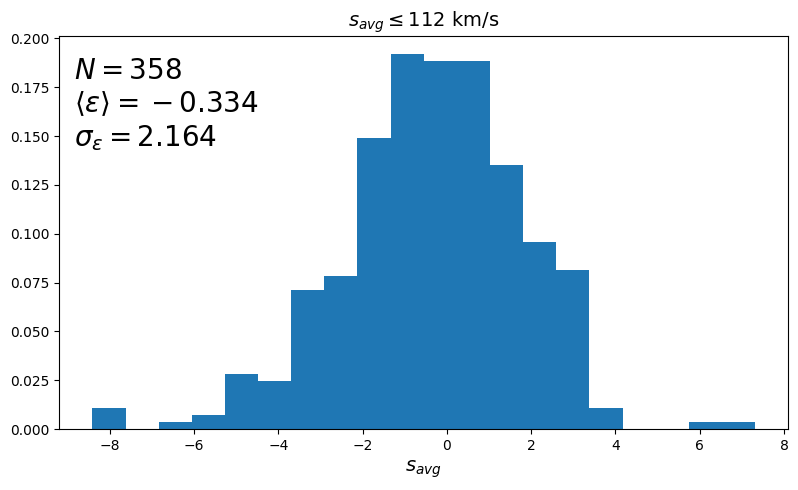

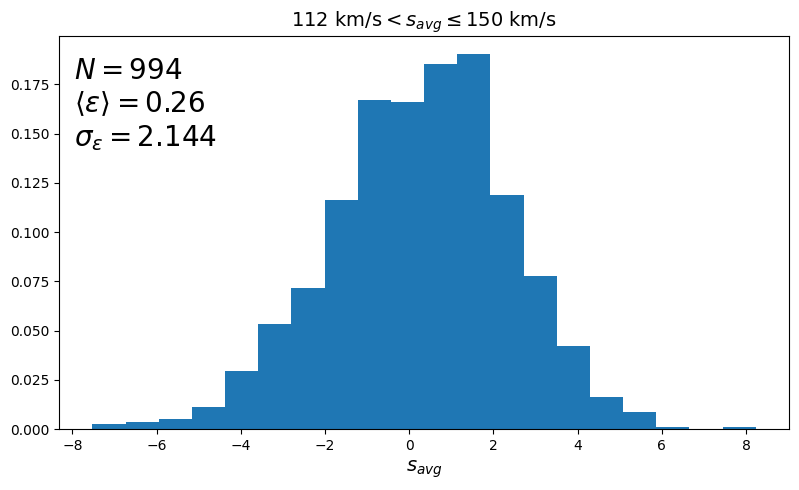

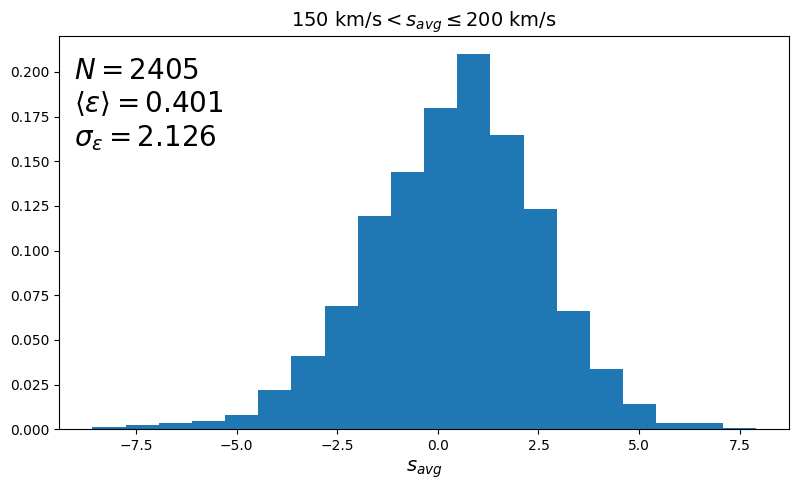

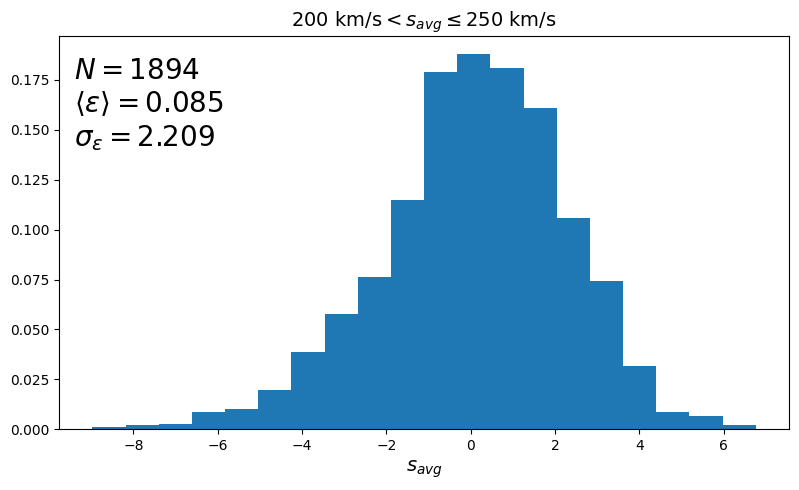

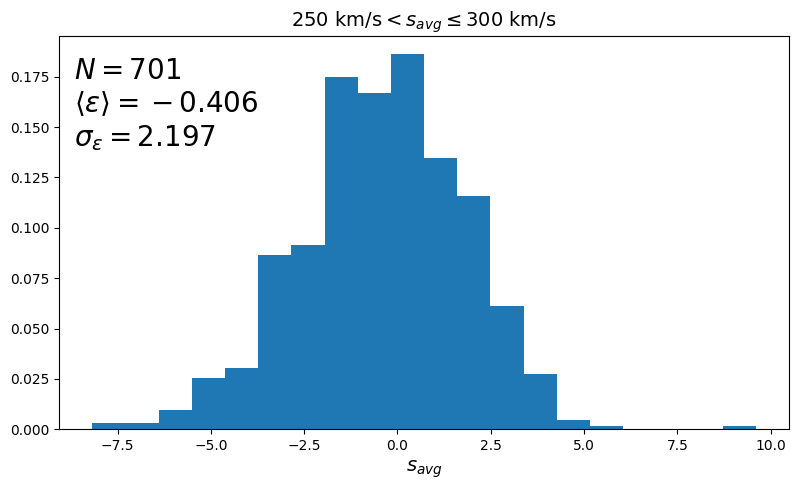

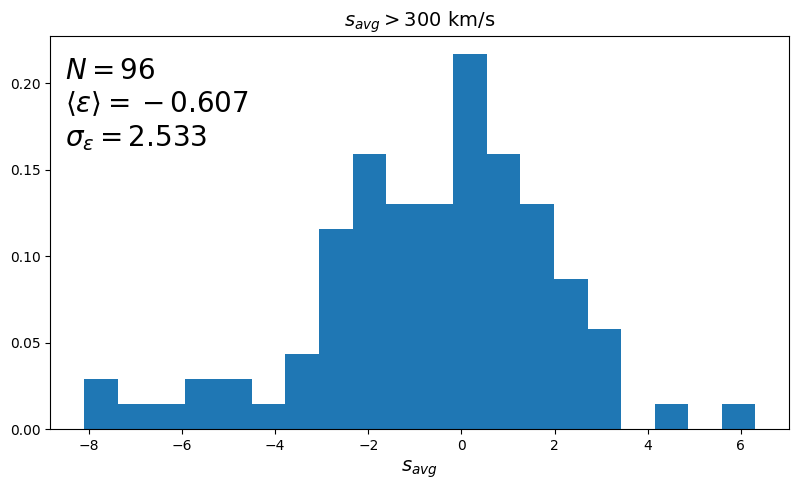

In [21]:
VELDISP_ORI_OUTPUT_FILEPATH = os.path.join(ROOT_PATH, 'data/processed/veldisp_calibrated/repeat_ori.csv')

df = pd.read_csv(VELDISP_ORI_OUTPUT_FILEPATH)
df = df[~(df['s_sdss'].isna()) & ~(df['s_lamost'].isna())]

# Calculate epsilon
df['epsilon'] = (df['s_sdss'] - df['s_lamost']) / np.sqrt(df['es_sdss']**2 + df['es_lamost']**2)
df = df[np.absolute(df['epsilon']) < 10.]
# Calculate the average (to avoid correlated errors)
df['s_avg'] = 0.5 * (df['s_sdss'] + df['s_lamost'])

# Prepare the bins
S_BIN_WIDTH = 50.
# bin_list = np.log10(np.arange(10**df['s_avg'].min(), 10**df['s_avg'].max() + S_BIN_WIDTH, S_BIN_WIDTH))
bin_list = np.log10(np.array([1., 112., 150., 200., 250., 300., 500.]))
bin_label = range(1, len(bin_list))
df['s_bin'] = pd.cut(df['s_avg'], bin_list, labels=bin_label)

plot_titles = {
    1: r'$s_{avg} \leq 112$ km/s',
    2: r'$112\ \text{km/s} < s_{avg} \leq 150$ km/s',
    3: r'$150\ \text{km/s} < s_{avg} \leq 200$ km/s',
    4: r'$200\ \text{km/s} < s_{avg} \leq 250$ km/s',
    5: r'$250\ \text{km/s} < s_{avg} \leq 300$ km/s',
    6: r'$s_{avg} > 300$ km/s'
}

for i in bin_label:
    df_slice = df[df['s_bin']==i]
    
    epsilon_mean = df_slice['epsilon'].mean()
    epsilon_std = df_slice['epsilon'].std()
    
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    ax.hist(df_slice['epsilon'], density=True, bins=20)
    ax.set_xlabel(r'$s_{avg}$', fontsize=14)
    ax.set_title(plot_titles[i], fontsize=14)
    
    # Add text
    text_string = fr'$N = {len(df_slice)}$' + '\n' + fr'$\langle\epsilon\rangle = {round(epsilon_mean, 3)}$' + "\n" + fr'$\sigma_\epsilon = {round(epsilon_std, 3)}$'
    ax.text(0.02, 0.72, s=text_string, transform = ax.transAxes, fontsize=20)
    
    # Save figure
    fig.tight_layout()
    fig.savefig(f'img/veldisp_calib/epsilon_bin_{i}.png', dpi=300)
    
    plt.show()

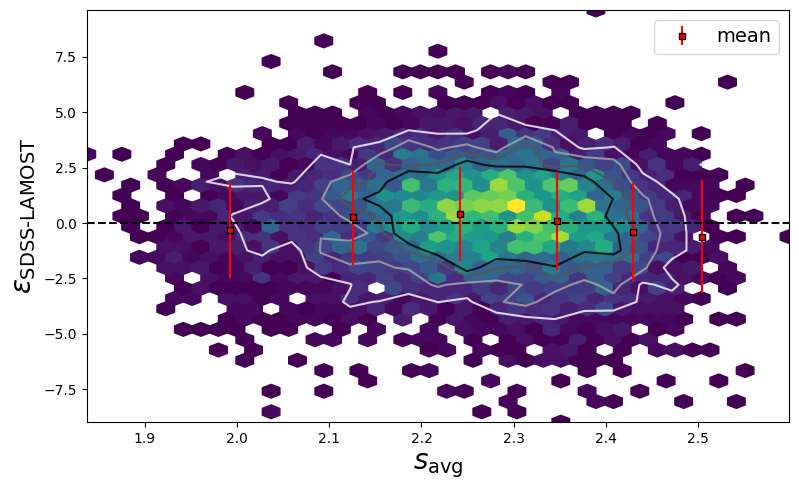

In [24]:
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

# Create hexbin plot and bin coordinate and its corresponding value
h = ax.hexbin(df['s_avg'], df['epsilon'], gridsize=(40, 20), mincnt=1)
xy = h.get_offsets()
x = xy[:, 0]
y = xy[:, 1]
v = h.get_array()

xi=np.linspace(x.min(), x.max(), 25)
yi=np.linspace(y.min(), y.max(), 25)

# Create contour plot
X,Y= np.meshgrid(xi,yi)
Z = griddata((x, y), v, (X, Y), method='cubic')
plt.contour(X, Y, Z, levels=[5, 10, 15, 20], cmap='gist_yarg', alpha=0.8)

# Create binned epsilon
df_grouped = df.groupby(['s_bin'], observed=False).agg(bin_count=('epsilon', 'count'), s_avg_mean=('s_avg', 'mean'), epsilon_mean=('epsilon', 'mean'), epsilon_std=('epsilon', 'std'))
df_grouped['mean_error'] = df_grouped['epsilon_std'] / np.sqrt(df_grouped['bin_count'])
plt.errorbar(x=df_grouped['s_avg_mean'], y=df_grouped['epsilon_mean'], yerr=df_grouped['epsilon_std'], marker='s', mfc='red',
         mec='k', ms=5, mew=1, ecolor='red', color='red', ls='none', label='mean')

# Create horizontal line
plt.axhline(y=0, color='k', ls='--')

# Labels and stuff
plt.xlabel(r'$s_\text{avg}$', fontsize=20)
plt.ylabel(r'$\epsilon_\text{SDSS-LAMOST}$', fontsize=20)
plt.legend(fontsize=14)

# Save figure
plt.tight_layout()
plt.savefig('img/veldisp_calib/epsilon_vs_savg.png', dpi=300)

plt.show()

# APPLY SELECTION CRITERIA

In [ ]:
INPUT_FILEPATH = {
    '6dFGS': ('data/processed/veldisp_calibrated/6dfgs.csv'),
    'SDSS': ('data/processed/veldisp_calibrated/sdss.csv'),
    'LAMOST': ('data/processed/veldisp_calibrated/lamost.csv')
}

# Selection criteria constants
UPPER_Z_LIMIT = 16120.0 / LIGHTSPEED
LOWER_Z_LIMIT = 3000.0 / LIGHTSPEED
UPPER_MAG_LIMIT = 13.65
LOWER_VELDISP_LIMIT = np.log10(112)

for survey in SURVEY_LIST:
    df = pd.read_csv(INPUT_FILEPATH[survey])
    old_count = len(df)
    print(f"Original number of galaxies in {survey}: {old_count}")
    
    # Apply upper CMB redshift limit
    df = df[df['z_dist_est'] <= UPPER_Z_LIMIT]
    new_count = len(df)
    print(f"Number of galaxies after cz <= 16120 = {new_count} | Discarded galaxies = {old_count - new_count}")
    old_count = new_count
    
    # Apply upper magnitude limit
    df = df[(df['j_m_ext'] - df['extinction_j']) <= UPPER_MAG_LIMIT]
    new_count = len(df)
    print(f"Number of galaxies after (m_j - extinction_j) <= 13.65 = {new_count} | Discarded galaxies = {old_count - new_count}")
    old_count = new_count
    
    # Apply upper veldisp limit
    df = df[df['s_scaled'] >= LOWER_VELDISP_LIMIT]
    new_count = len(df)
    print(f"Number of galaxies after s_scaled >= log10(112) + 6dFGS_offset = {new_count} | Discarded galaxies = {old_count - new_count}")
    old_count = new_count
    
    # Apply lower CMB redshift limit
    df_high_z = df[df['z_dist_est'] >= LOWER_Z_LIMIT]
    new_count = len(df_high_z)
    print(f"Number of galaxies after cz >= 3000 = {new_count} | Discarded galaxies = {old_count - new_count}")
    
    # Save the remaining high-redshift galaxies
#     df_high_z.to_csv()
    
    # Save the low-redshift galaxies (will not be used to fit the FP due to high scatter but PVs will still be measured)
    df_low_z = df[df['z_dist_est'] <= LOWER_Z_LIMIT]
    print(f"Number of galaxies with cz <= 3000 = {len(df_low_z)}")
#     df_low_z.to_csv()

    print('\n')

# SELECT ETG (skipped for now)

In [ ]:

survey = 'LAMOST'
INPUT_FILEPATH = {
    '6dFGS': os.path.join(ROOT_PATH, 'data/processed/veldisp_calibrated/6dfgs.csv'),
    'SDSS': os.path.join(ROOT_PATH, 'data/processed/veldisp_calibrated/sdss.csv'),
    'LAMOST': os.path.join(ROOT_PATH, 'data/processed/veldisp_calibrated/lamost.csv')
}

HIGH_Z_OUTPUT_FILEPATH = {
    '6dFGS': os.path.join(ROOT_PATH, 'data/processed/zms_cut/6dfgs.csv'),
    'SDSS': os.path.join(ROOT_PATH, 'data/processed/zms_cut/sdss.csv'),
    'LAMOST': os.path.join(ROOT_PATH, 'data/processed/zms_cut/lamost.csv')
}

LOW_Z_OUTPUT_FILEPATH = {
    '6dFGS': os.path.join(ROOT_PATH, 'data/processed/zms_cut/low_z/6dfgs.csv'),
    'SDSS': os.path.join(ROOT_PATH, 'data/processed/zms_cut/low_z/sdss.csv'),
    'LAMOST': os.path.join(ROOT_PATH, 'data/processed/zms_cut/low_z/lamost.csv')
}

LAMOST_GOOD_PV_LIST_FILEPATH = os.path.join(ROOT_PATH, 'data/raw/r_e_jrl/lamost_good_pv_list.csv')

# Grab 6dFGS offset
totoff = pd.read_csv(os.path.join(ROOT_PATH, 'data/processed/veldisp_calibrated/totoffs.csv'))
off_6df = 0.0 # totoff.loc[0, ['off_6df']].values[0]

# Selection criteria constants
UPPER_Z_LIMIT = 16120.0 / LIGHTSPEED
LOWER_Z_LIMIT = 3000.0 / LIGHTSPEED
UPPER_MAG_LIMIT = 13.65
LOWER_VELDISP_LIMIT = np.log10(112) - off_6df

print(f"{'=' * 25} {survey} {'=' * 25}")

df = pd.read_csv(INPUT_FILEPATH[survey])
old_count = len(df)
print(f"Original number of galaxies in {survey}: {old_count}")

# 1. Apply upper CMB redshift limit
df = df[df['z_dist_est'] <= UPPER_Z_LIMIT]
new_count = len(df)
print(f"Number of galaxies after cz <= 16120 = {new_count} | Discarded galaxies = {old_count - new_count}")
old_count = new_count

# 2. Apply lower CMB redshift limit
df_high_z = df[df['z_dist_est'] >= LOWER_Z_LIMIT]
new_count = len(df_high_z)
print(f"Number of galaxies after cz >= 3000 = {new_count} | Discarded galaxies = {old_count - new_count}")
old_count = new_count

# 3. Apply upper magnitude limit
df_high_z = df_high_z[(df_high_z['j_m_ext'] - df_high_z['extinction_j']) <= UPPER_MAG_LIMIT]
new_count = len(df_high_z)
print(f"Number of galaxies after (m_j - extinction_j) <= 13.65 = {new_count} | Discarded galaxies = {old_count - new_count}")
old_count = new_count

# 4. Apply upper veldisp limit
df_high_z = df_high_z[df_high_z['s_scaled'] >= LOWER_VELDISP_LIMIT]
new_count = len(df_high_z)
print(f"Number of galaxies after s_scaled >= log10(112) - 6dFGS_offset ({round(off_6df, 3)}) = {new_count} | Discarded galaxies = {old_count - new_count}")
old_count = new_count

# 5. Select the low-redshift galaxies (will not be used to fit the FP due to high scatter but PVs will still be measured)
df_low_z = df[(df['z_dist_est'] <= LOWER_Z_LIMIT) & ((df['j_m_ext'] - df['extinction_j']) <= UPPER_MAG_LIMIT) & (df['s_scaled'] >= LOWER_VELDISP_LIMIT)]

# 6. For LAMOST, select galaxies classified as ETG from John's visual inspections
if survey == 'LAMOST':
    good_pv_list = pd.read_csv(LAMOST_GOOD_PV_LIST_FILEPATH)[['col1']]
    df_high_z = df_high_z.merge(good_pv_list, left_on='tmass', right_on='col1', how='inner').drop(['col1'], axis=1)
    print(f"Number of LAMOST galaxies after visual inspection = {len(df_high_z)} | Discarded galaxies = {old_count - len(df_high_z)}")
    df_low_z = df_low_z.merge(good_pv_list, left_on='tmass', right_on='col1', how='inner').drop(['col1'], axis=1)
    
# Save the remaining high-redshift galaxies
df_high_z.to_csv(HIGH_Z_OUTPUT_FILEPATH[survey], index=False)

# Save the low-redshift galaxies
print(f"Number of galaxies with cz <= 3000 = {len(df_low_z)}")
df_low_z.to_csv(LOW_Z_OUTPUT_FILEPATH[survey], index=False)

print('\n')

In [ ]:
pd.read_csv('data/processed/zms_cut/6dfgs.csv').columns

# DERIVE PHOTOMETRIC ERRORS AND GRAB FINAL COLUMNS

## Combine all the measurements

In [ ]:
pd.read_csv(INPUT_FILEPATH['6dFGS']).columns

Deriving photometric errors...
Iteration 1
Parameters: x0 = 10.4378
y0 = 0.0347
k = 0.0159
Constant = -0.1316
Iteration 2
Parameters: x0 = 11.0475
y0 = 0.0362
k = 0.0205
Constant = -0.1903
Iteration 3
Parameters: x0 = 10.9913
y0 = 0.0351
k = 0.0205
Constant = -0.1903
popt = [10.99131497  0.03505303  0.02050585]
Equation: y = 0.0351 for x <= 10.9913
Equation: y = 0.0205m_J + (-0.1903) for x > 10.9913
Deriving photometric errors successful!


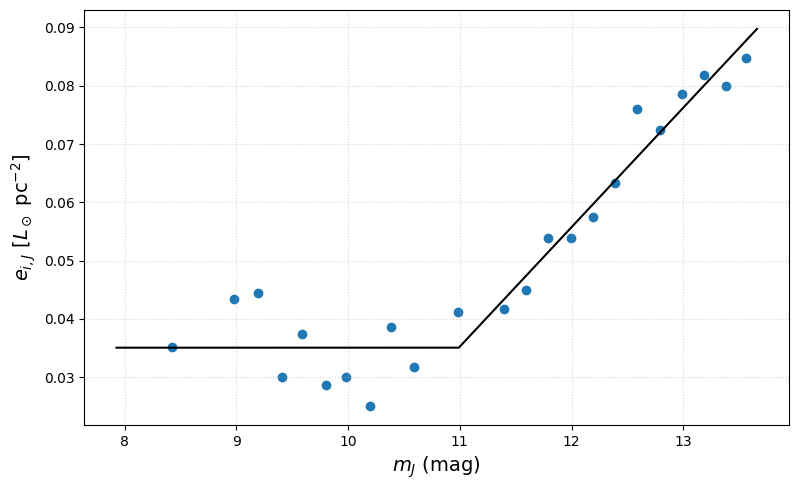

In [13]:
# Constant
MAG_BIN_WIDTH = 0.2    # magnitude bin width

GLOBAL_REQ_COL = ['ra', 'dec', 'zhelio', 'z_cmb', 'z_dist_est', 'j_m_ext', 'extinction_j', 'kcor_j', 'r_j', 'er_j', 's_scaled', 'es_scaled', 'i_j', 'ei_j']
REQ_COLS = {
    '6dFGS': ['tmass', '_6dFGS'] + GLOBAL_REQ_COL,
    'SDSS': ['tmass', 'objid'] + GLOBAL_REQ_COL,
    'LAMOST': ['tmass', 'obsid'] + GLOBAL_REQ_COL
}

INPUT_FILEPATH = {
    '6dFGS': 'data/processed/zms_cut/6dfgs.csv',
    'SDSS': 'data/processed/zms_cut/sdss.csv',
    'LAMOST': 'data/processed/zms_cut/lamost.csv'
}

OUTPUT_FILEPATH = {
    '6dFGS': 'data/foundation/fp_sample/6dfgs.csv',
    'SDSS': 'data/foundation/fp_sample/sdss.csv',
    'LAMOST': 'data/foundation/fp_sample/lamost.csv'
}

# Piecewise linear function
def piecewise_linear(x, x0, y0, k):
    '''
    A function that is constant at x <= x0, and linear at x > x0.
    '''
    y_pred = np.piecewise(x, [x <= x0, x > x0], [lambda x: y0, lambda x: k * (x - x0) + y0])
    return y_pred

# Function to derive the photometric error
def derive_phot_error():
    '''
    A function to derive the photometric errors following the method outlined in Magoulas et al. 2012.
    The scatter vs magnitude is fit with the piecewise linear function iteratively to remove outliers.
    '''
    df = pd.DataFrame()
    for survey in SURVEY_LIST:
        req_cols = ['tmass', 'j_m_ext', 'extinction_j', 'i_j', 'i_h', 'i_k']
        df_survey = pd.read_csv(INPUT_FILEPATH[survey])[req_cols]
        df = pd.concat([df, df_survey])

    df = df.drop_duplicates(subset='tmass')

    # Calculate extinction-corrected J-band magnitude
    df['mag_j'] = df['j_m_ext'] - df['extinction_j']

    # Calculate all colors
    df['color_jh'] = df['i_j'] - df['i_h']
    df['color_jk'] = df['i_j'] - df['i_k']
    df['color_hk'] = df['i_h'] - df['i_k']

    # Create the magnitude bins
    bin_list = np.arange(df['mag_j'].min(), df['mag_j'].max() + MAG_BIN_WIDTH, MAG_BIN_WIDTH)
    bin_label = range(1, len(bin_list))
    df['mag_j_bin'] = pd.cut(df['mag_j'], bin_list, labels=bin_label)

    # Calculate the variance of the colors in each bin
    delta2_jh = df.groupby('mag_j_bin', observed=False)['color_jh'].var()
    delta2_jk = df.groupby('mag_j_bin', observed=False)['color_jk'].var()
    delta2_hk = df.groupby('mag_j_bin', observed=False)['color_hk'].var()
    mag_j_bin_mean = df.groupby('mag_j_bin', observed=False)['mag_j'].mean()

    # Calculate the error in j alone
    e_i_j = np.sqrt(0.5 * (delta2_jh + delta2_jk - delta2_hk))

    # Remove nan values
    notnan_indices = ~np.isnan(e_i_j)
    e_i_j = e_i_j[notnan_indices].to_numpy()
    mag_j_bin_mean = mag_j_bin_mean[notnan_indices].to_numpy()

    # Fit the function iteratively
    x_data = mag_j_bin_mean
    y_data = e_i_j
    datacount = len(y_data)
    is_converged = False
    i = 1
    while not is_converged:
        print(f"Iteration {i}")
        # Fit the parameters
        popt, pcov = curve_fit(piecewise_linear, x_data, y_data, p0=[11.0, 0.02, 0.05])
        print(f'Parameters: x0 = {round(popt[0], 4)}')
        print(f'y0 = {round(popt[1], 4)}')
        print(f'k = {round(popt[2], 4)}')
        print(f'Constant = {round(popt[1] - popt[2] * popt[0], 4)}')

        # Calculate the predicted values and chi statistics
        y_pred = piecewise_linear(x_data, *popt)
        chisq = ((y_data - y_pred) / y_pred)**2

        # Reject the 'bad' data (chisq > 0.5)
        bad_data_indices = chisq > 0.1
        x_data = x_data[~bad_data_indices]
        y_data = y_data[~bad_data_indices]
        datacount_new = len(y_data)

        is_converged = True if datacount == datacount_new else False
        datacount = datacount_new
        i += 1
    
    # Print the final equation
    print(f"popt = {popt}")
    constant_pl = round(popt[1] - popt[2] * popt[0], 4)
    print(f"Equation: y = {popt[1]:.4f} for x <= {popt[0]:.4f}")
    print(f"Equation: y = {popt[2]:.4f}m_J + ({constant_pl:.4f}) for x > {popt[0]:.4f}")

    # Plot the results
    x_trial = np.linspace(np.min(x_data) - 0.5, np.max(x_data) + 0.1, 1000)
    y_trial = piecewise_linear(x_trial, *popt)

    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    ax.scatter(x_data, y_data)
    ax.plot(x_trial, y_trial, color='k')
    ax.set_xlabel(r'$m_J$ (mag)', fontsize=14)
    ax.set_ylabel(r'$e_{i,J}$ [$L_\odot\ \text{pc}^{-2}$]', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(ls=':', alpha=0.5)
    plt.tight_layout()
    img_output_path = os.path.join(ROOT_PATH, f'img/phot_error.png')
    fig.savefig(img_output_path, dpi=300)
    
    return popt
    
def apply_phot_error(popt):
    '''
    This function applies the error formula for every galaxy.
    '''
    for survey in SURVEY_LIST:
        df = pd.read_csv(INPUT_FILEPATH[survey])
        df['ei_j'] = piecewise_linear(np.array(df['j_m_ext'] - df['extinction_j']), *popt)
        df['er_j'] = 0.5 * df['ei_j']
        df = df[REQ_COLS[survey]].rename({'r_j': 'r', 'er_j': 'er', 's_scaled': 's', 'es_scaled': 'es', 'i_j': 'i', 'ei_j': 'ei'}, axis=1)
#         df.to_csv(OUTPUT_FILEPATH[survey], index=False)
        
def main():
    print("Deriving photometric errors...")
    popt = derive_phot_error()
    print("Deriving photometric errors successful!")
    
#     print("Applying photometric errors and selecting the final columns...")
#     apply_phot_error(popt)
#     print("Applying photometric errors and selecting the final columns successful!")
    
if __name__ == '__main__':
    main()

# Compare FP parameters

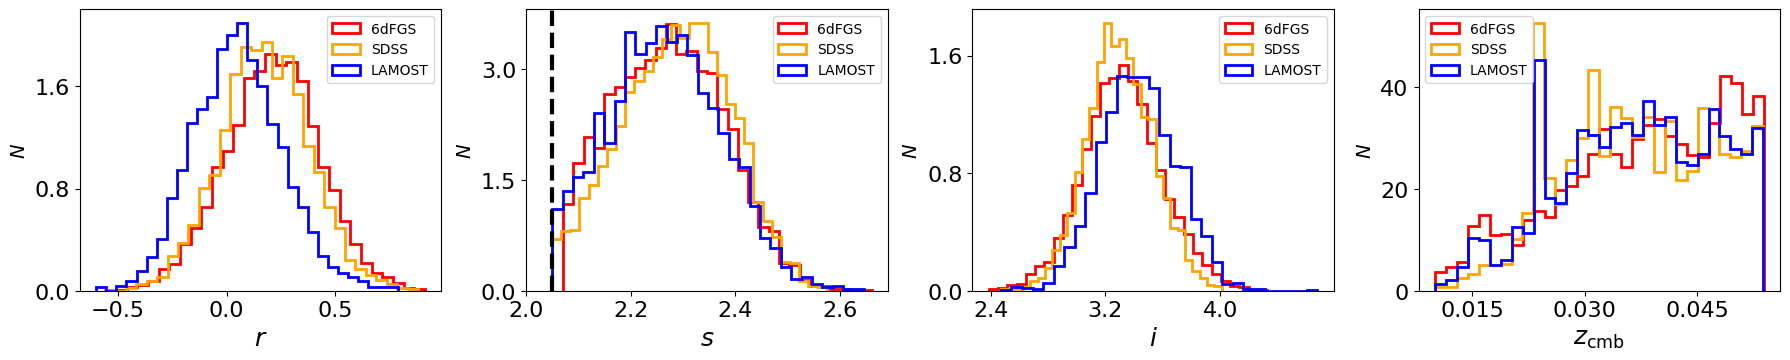

In [19]:
tick_fontsize = 16
xlabel_fontsize = 18
ylabel_fontsize = 14
max_xticks = 4
max_yticks = 3

# Open file
# filename = '6dfgs'
df_6df = pd.read_csv('data/foundation/fp_sample/6dfgs.csv')
df_sdss = pd.read_csv('data/foundation/fp_sample/sdss.csv')
df_lamost = pd.read_csv('data/foundation/fp_sample/lamost.csv')

# Physical radii
r_6df = df_6df['r']
r_sdss = df_sdss['r']
r_lamost = df_lamost['r']

# Velocity dispersions
s_6df = df_6df['s']
s_sdss = df_sdss['s']
s_lamost = df_lamost['s']

# Brightness
i_6df = df_6df['i']
i_sdss = df_sdss['i']
i_lamost = df_lamost['i']

# Redshift
z_6df = df_6df['z_dist_est']
z_sdss = df_sdss['z_dist_est']
z_lamost = df_lamost['z_dist_est']

# Make figures
golden_ratio = 1.618
width = 6.
nbins = 30
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(width*3, width/golden_ratio))

kwargs_6df = {'density': True, 'alpha': 1., 'histtype': 'step', 'edgecolor': 'red', 'linewidth': 2., 'label': '6dFGS'}
kwargs_sdss = {'density': True, 'alpha': 1., 'histtype': 'step', 'edgecolor': 'orange', 'linewidth': 2., 'label': 'SDSS'}
kwargs_lamost = {'density': True, 'alpha': 1., 'histtype': 'step', 'edgecolor': 'blue', 'linewidth': 2., 'label': "LAMOST"}

ax1.hist(r_6df, bins=nbins, **kwargs_6df)
ax1.hist(r_sdss, bins=nbins, **kwargs_sdss)
ax1.hist(r_lamost, bins=nbins, **kwargs_lamost)
ax1.set_xlabel(r'$r$', fontsize=xlabel_fontsize)
ax1.set_ylabel(r'$N$', fontsize=ylabel_fontsize)
ax1.xaxis.set_major_locator(plt.MaxNLocator(max_xticks))
ax1.yaxis.set_major_locator(plt.MaxNLocator(max_yticks))
ax1.tick_params(axis='both', labelsize=tick_fontsize)
ax1.legend()

ax2.hist(s_6df, bins=nbins, **kwargs_6df)
ax2.hist(s_sdss, bins=nbins, **kwargs_sdss)
ax2.hist(s_lamost, bins=nbins, **kwargs_lamost)
ax2.axvline(x=np.log10(112), c='k', ls='--', lw=3)
ax2.set_xlim(left=2.0)
ax2.set_xlabel(r'$s$', fontsize=xlabel_fontsize)
ax2.set_ylabel(r'$N$', fontsize=ylabel_fontsize)
ax2.xaxis.set_major_locator(plt.MaxNLocator(max_xticks))
ax2.yaxis.set_major_locator(plt.MaxNLocator(max_yticks))
ax2.tick_params(axis='both', labelsize=tick_fontsize)
ax2.legend()

ax3.hist(i_6df, bins=nbins, **kwargs_6df)
ax3.hist(i_sdss, bins=nbins, **kwargs_sdss)
ax3.hist(i_lamost, bins=nbins, **kwargs_lamost)
ax3.set_xlabel(r'$i$', fontsize=xlabel_fontsize)
ax3.set_ylabel(r'$N$', fontsize=ylabel_fontsize)
ax3.xaxis.set_major_locator(plt.MaxNLocator(max_xticks))
ax3.yaxis.set_major_locator(plt.MaxNLocator(max_yticks))
ax3.tick_params(axis='both', labelsize=tick_fontsize)
ax3.legend()

ax4.hist(z_6df, bins=nbins, **kwargs_6df)
ax4.hist(z_sdss, bins=nbins, **kwargs_sdss)
ax4.hist(z_lamost, bins=nbins, **kwargs_lamost)
ax4.set_xlabel(r'$z_\text{cmb}$', fontsize=xlabel_fontsize)
ax4.set_ylabel(r'$N$', fontsize=ylabel_fontsize)
ax4.xaxis.set_major_locator(plt.MaxNLocator(max_xticks))
ax4.yaxis.set_major_locator(plt.MaxNLocator(max_yticks))
ax4.tick_params(axis='both', labelsize=tick_fontsize)
ax4.legend()

# # Plot color distributions
# df_color = pd.read_table('../data/raw_data/r_e_jrl/colours.ascii', delim_whitespace=True)
# df_color.rename(columns={'tmass':'2MASS'}, inplace=True)

# df_6df_color = data1.merge(df_color, on='2MASS')
# df_6df_color['extinction_k'] = (0.31/0.723)*df_6df_color['extinction_j']

# df_sl_color = data2.merge(df_color, on='2MASS')
# df_sl_color['extinction_k'] = (0.31/0.723)*df_sl_color['extinction_j']

# ax4.hist(df_6df_color['J_K_5']-(df_6df_color['extinction_j']-df_6df_color['extinction_k']), bins=100, density=True, alpha=0.4, color='red')
# ax4.hist(df_sl_color['J_K_5']-(df_sl_color['extinction_j']-df_sl_color['extinction_k']), bins=100, density=True, alpha=0.4, color='blue')
# ax4.set_xlabel(r'$J_5-K_5$', fontsize=xlabel_fontsize)
# ax4.set_ylabel(r'$N$', fontsize=ylabel_fontsize)
# ax4.xaxis.set_major_locator(plt.MaxNLocator(max_xticks))
# ax4.yaxis.set_major_locator(plt.MaxNLocator(max_yticks))
# ax4.tick_params(axis='both', labelsize=tick_fontsize)
# ax4.set_xlim(0.8,1.20)


plt.tight_layout()
# plt.savefig('../images/param_distributions.png', dpi=300)

plt.show()

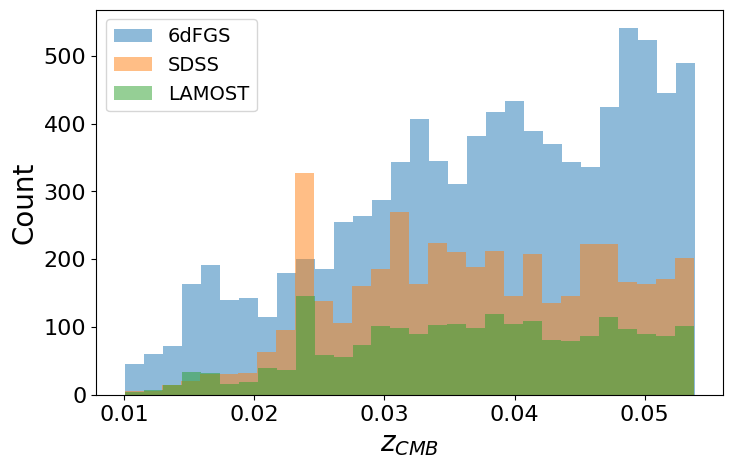

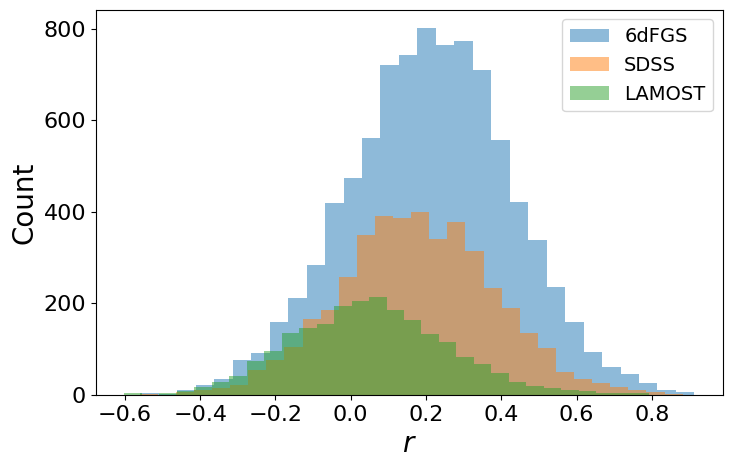

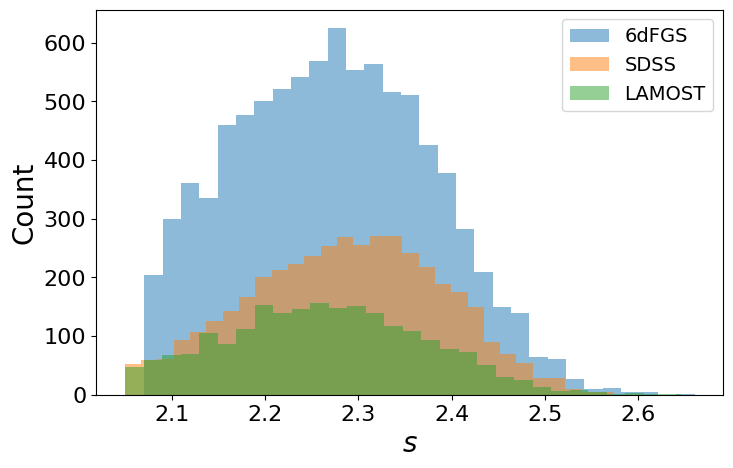

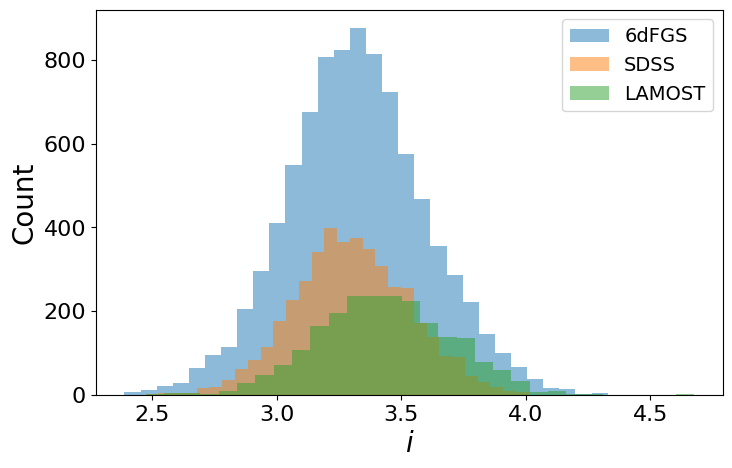

In [18]:
tick_fontsize = 16
xlabel_fontsize = 18
ylabel_fontsize = 14
max_xticks = 4
max_yticks = 3

# Open file
# filename = '6dfgs'
df_6df = pd.read_csv('data/foundation/fp_sample/6dfgs.csv')
df_sdss = pd.read_csv('data/foundation/fp_sample/sdss.csv')
df_lamost = pd.read_csv('data/foundation/fp_sample/lamost.csv')

# Physical radii
r_6df = df_6df['r']
r_sdss = df_sdss['r']
r_lamost = df_lamost['r']

# Velocity dispersions
s_6df = df_6df['s']
s_sdss = df_sdss['s']
s_lamost = df_lamost['s']

# Brightness
i_6df = df_6df['i']
i_sdss = df_sdss['i']
i_lamost = df_lamost['i']

# Redshift
z_6df = df_6df['z_dist_est']
z_sdss = df_sdss['z_dist_est']
z_lamost = df_lamost['z_dist_est']

# Plot redshift
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
ax.hist(z_6df, bins=30, alpha=0.5, label='6dFGS')
ax.hist(z_sdss, bins=30, alpha=0.5, label='SDSS')
ax.hist(z_lamost, bins=30, alpha=0.5, label='LAMOST')
ax.set_xlabel(r'$z_{CMB}$', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.tick_params(axis='both', labelsize=tick_fontsize)
ax.legend(fontsize=14)

# Plot radii
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
ax.hist(r_6df, bins=30, alpha=0.5, label='6dFGS')
ax.hist(r_sdss, bins=30, alpha=0.5, label='SDSS')
ax.hist(r_lamost, bins=30, alpha=0.5, label='LAMOST')
ax.set_xlabel(r'$r$', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.tick_params(axis='both', labelsize=tick_fontsize)
ax.legend(fontsize=14)

# Plot veldisp
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
ax.hist(s_6df, bins=30, alpha=0.5, label='6dFGS')
ax.hist(s_sdss, bins=30, alpha=0.5, label='SDSS')
ax.hist(s_lamost, bins=30, alpha=0.5, label='LAMOST')
ax.set_xlabel(r'$s$', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.tick_params(axis='both', labelsize=tick_fontsize)
ax.legend(fontsize=14)

# Plot brightnesses
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
ax.hist(i_6df, bins=30, alpha=0.5, label='6dFGS')
ax.hist(i_sdss, bins=30, alpha=0.5, label='SDSS')
ax.hist(i_lamost, bins=30, alpha=0.5, label='LAMOST')
ax.set_xlabel(r'$i$', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.tick_params(axis='both', labelsize=tick_fontsize)
ax.legend(fontsize=14)

plt.show()